# Preprocessing

Installazione librerie e setup ambiente

In [1]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [2]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time


In [3]:
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Userai:", device)

GPU disponibile: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Userai: cuda


Collegamento al drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [5]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [6]:
%ls /content/drive/MyDrive/HumanData/ESC-10/


chainsaw/    crackling_fire/  dog/         rain/     sea_waves/
clock_tick/  crying_baby/     helicopter/  rooster/  sneezing/


## Processare tutti i file audio di ESC10

In [7]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100  # non fare downsampling
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 512
DURATION = 5.0       # lunghezza standard (secondi)
BATCH_SIZE = 32

class ESCLabels(Enum):
    chainsaw = 0
    clock_tick = 1
    crackling_fire = 2
    crying_baby = 3
    dog = 4
    helicopter = 5
    rain = 6
    rooster = 7
    sea_waves = 8
    sneezing = 9

- Se un audio ha una frequenza di campionamento di 44.1 kHz, significa che ogni secondo è rappresentato da 44.100 campioni (numeri). Più alta è la frequenza, più dettagliato sarà il suono (fino a un certo limite). 44.1 kHz è sufficiente per rappresentare tutte le frequenze udibili dall’orecchio umano (fino a ~20 kHz), secondo il teorema di Nyquist.

- Trim + Normalizzazione: rimuovo silenzio per non sprecare tempo computazionale su dati inutili. Scalare il segnale in [-1,1] in modo da rimuovere il bias di ampiezza tra clip (evita che la rete impari "volume=classe")

- Con la normalizzazione vado a modificare il range dell'ampiezza, cioè quanto forte o debole è il segnale

per ora non trimmo i silenzio --> possibile ablation study con e senza trim

Perché NON usare trim:
Mantieni la coerenza temporale tra le clip
→ fondamentale per SNN e spike encoding, che sono sensibili alla sequenza temporale dei pattern.

Eviti disallineamenti introdotti da librosa.effects.trim
→ anche 0.2 secondi di shift possono alterare l’input percepito dal modello.

Se usi segmenti (chunk) fissi via timesteps=50,
→ i segmenti devono sempre partire dallo stesso punto temporale.

In [8]:
def load_audio_file(file_path, sr=SAMPLE_RATE, duration=5.0, top_db = 30):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    #y, _ = librosa.effects.trim(y, top_db=top_db)           # elimina silence iniziale e finale
    y = librosa.util.normalize(y)           # normalizzazione RMS
    #if len(y) < int(sr * duration):
    #    padding = int(sr * duration) - len(y)
    #    y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

controllo di quanto silenzio toglie

In [9]:
# total_trimmed_start = 0.0
# total_trimmed_end = 0.0
# clip_count = 0

# for label in sorted(os.listdir(BASE_PATH)):
#     class_path = os.path.join(BASE_PATH, label)
#     for file in os.listdir(class_path):
#         if file.endswith(".wav"):
#             file_path = os.path.join(class_path, file)

#             # Carica audio
#             y, sr = librosa.load(file_path, sr=44100, duration=5.0)

#             # Applica trim
#             y_trimmed, index = librosa.effects.trim(y, top_db=30)
#             start_sample, end_sample = index

#             # Converti in secondi
#             start_sec = start_sample / sr
#             end_sec = (len(y) - end_sample) / sr

#             total_trimmed_start += start_sec
#             total_trimmed_end += end_sec
#             clip_count += 1

#             print(f"{file} → Trim: start={start_sec:.2f}s, end={end_sec:.2f}s")

# # Statistiche finali
# print("\n--- STATISTICHE TOTALI ---")
# print(f"Clip analizzati: {clip_count}")
# print(f"Silenzio medio INIZIALE tagliato: {total_trimmed_start / clip_count:.2f} s")
# print(f"Silenzio medio FINALE tagliato: {total_trimmed_end / clip_count:.2f} s")


In [10]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [02:46<00:00, 16.61s/it]


In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.4, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 240, Val: 80, Test: 80


## NAA

In [12]:
def center_crop(signal, target_len):
    if len(signal) < target_len:
        pad_left = (target_len - len(signal)) // 2
        pad_right = target_len - len(signal) - pad_left
        return np.pad(signal, (pad_left, pad_right), mode='constant')
    else:
        start = (len(signal) - target_len) // 2
        return signal[start:start + target_len]

In [13]:
def naa(y, sr):
    augmented = []
    target_len = int(sr * 5.0)

    # Originale
    augmented.append(center_crop(y, target_len))

    # Pitch shift
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2), target_len))
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2), target_len))

    # Time stretch
    for rate in [0.7, 1.2]:
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        augmented.append(center_crop(y_stretched, target_len))

    return augmented

In [14]:

X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))

NAA: 100%|██████████| 240/240 [00:59<00:00,  4.04it/s]


In [15]:

# Calcola le lunghezze di tutti gli audio
lengths = [len(x) for x in X_train_aug]

# Trova il minimo e il massimo
min_len = min(lengths)
max_len = max(lengths)

# Converti in secondi (facoltativo)
min_sec = min_len / SAMPLE_RATE
max_sec = max_len / SAMPLE_RATE

print(f"Audio più corto: {min_len} samples ({min_sec:.2f} s)")
print(f"Audio più lungo: {max_len} samples ({max_sec:.2f} s)")

Audio più corto: 220500 samples (5.00 s)
Audio più lungo: 220500 samples (5.00 s)


## Converti in log-Mel

- power_to_db(..., ref=np.max) normalizza ogni spettrogramma rispetto al suo massimo → rende il contrasto tra le bande più utile per la rete. Misura quanto ogni frequenza è forte rispetto al picco. Ha senso np.max perchè ho già normalizzato l'audio a [-1,1] quindi non hai una loudness assoluta. Per la classificazione di suoni ambientali il pattern spettrale è più importante del volume, voglio che ogni clip sia trattato in modo coerente (garantisce scale relative)

- power_to_db(..., ref=np.max) converte il Mel-spectrogramma da potenza lineare (espressa in unità numeriche) a decibel (scala logaritmica)

- il risultato più intenso avrà valore 0 dB. -80 invece significa “tutto ciò che è almeno 10⁸ volte più debole del valore massimo, consideralo praticamente silenzio”. La scala è negativa perchè stai calcolando il logaritmo del rapporto tra ogni valore del Mel-spect e il valore massimo di quel mel-spect



In [16]:
def preprocess_audio(y, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


Clipping dei frame troppo silenziosi

In [17]:
def clip_silent_frames(mel, threshold_db=-70.0):
    silent_mask = np.all(mel < threshold_db, axis=0)
    mel[:, silent_mask] = threshold_db  # o np.mean(mel)
    return mel

In [18]:
def batch_logmel(X, sr=SAMPLE_RATE):
    mel_list = []
    for x in tqdm(X, desc="Log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        # mel = clip_silent_frames(mel)
        mel_list.append(mel)
    return mel_list

In [19]:

X_train_mel = batch_logmel(X_train_aug)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)

"""
X_train_mel = batch_logmel(X_train)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)
"""

Log-Mel: 100%|██████████| 80/80 [00:00<00:00, 108.60it/s]


'\nX_train_mel = batch_logmel(X_train)\nX_val_mel = batch_logmel(X_val)\nX_test_mel = batch_logmel(X_test)\n'

In [20]:
print("Train set:", len(X_train_mel))
print("Val set:", len(X_val_mel))
print("Test set:", len(X_test_mel))

print("Shape primo sample train:", X_train_mel[0].shape)

Train set: 1200
Val set: 80
Test set: 80
Shape primo sample train: (128, 431)


visualizzo logmel spect

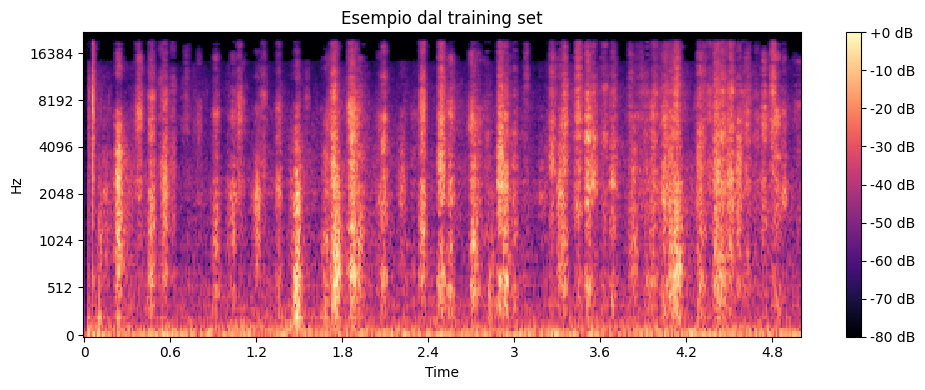

Class:  sea_waves


In [21]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualizza un esempio a caso dal training set
sample_idx = 32
show_mel(X_train_mel[sample_idx], title="Esempio dal training set")
print("Class: ", ESCLabels(y_train[sample_idx]).name)


In [22]:
all_vals = np.concatenate([mel.flatten() for mel in X_train_mel])
print("Min:", np.min(all_vals))
print("Max:", np.max(all_vals))

Min: -80.0
Max: 0.0


Padding per uniformare a 450

In [23]:
def pad_to_multiple_of(mel, multiple=50, value=-80.0):
    # Pads mel spectrogram along time axis to make time frames a multiple of 'multiple'
    current_len = mel.shape[1]
    target_len = ((current_len + multiple - 1) // multiple) * multiple
    pad_width = target_len - current_len
    return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=value)

In [24]:
# Applica padding a multiplo di 50 (compatibile con timesteps=50)
X_train_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_train_mel]
X_val_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_val_mel]
X_test_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_test_mel]

In [25]:
print("Train shape esempio:", X_train_mel[0].shape)
print("Val shape esempio:", X_val_mel[0].shape)
print("Test shape esempio:", X_test_mel[0].shape)

Train shape esempio: (128, 450)
Val shape esempio: (128, 450)
Test shape esempio: (128, 450)


## DATA AUG TAA

applicare taa dopo normalizzazione perchè imagedatagenerator lavora bene su [0,1]

In [26]:
"""
taa_generator = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.3,
    fill_mode='nearest'
)
"""

"\ntaa_generator = ImageDataGenerator(\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    zoom_range=0.25,\n    shear_range=0.3,\n    fill_mode='nearest'\n)\n"

In [27]:
X_train_mel_np = np.array(X_train_mel)
X_val_mel_np = np.array(X_val_mel)
X_test_mel_np = np.array(X_test_mel)

if len(X_train_mel_np.shape) == 3:
    X_train_mel_np = X_train_mel_np[..., np.newaxis]  # (N, 64, 431, 1)

y_train_np = np.array(y_train_aug)  # Etichette corrispondenti
# y_train_np = np.array(y_train)

### Normalizzazione:
i modelli funzionano meglio con input compresi tra 0 e 1.
0 = silenzio
1 = banda più forte

In [28]:
X_train_mel_np = (X_train_mel_np + 80.0) / 80.0
X_val_mel_np = (X_val_mel_np + 80.0) / 80.0
X_test_mel_np = (X_test_mel_np + 80.0) / 80.0

### TAA

In [29]:
"""
X_taa = []
y_taa = []

augmentations_per_sample = 4  # puoi aumentare questo numero

for i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):
    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)
    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)

    # Genera augmentazioni
    gen = taa_generator.flow(sample, batch_size=1)
    for _ in range(augmentations_per_sample):
        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)
        X_taa.append(aug_sample)
        y_taa.append(y_train_np[i])

# Combina con il training set originale
X_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)
y_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)

print("Nuova shape X:", X_train_augmented.shape)
print("Nuova shape y:", y_train_augmented.shape)
"""

'\nX_taa = []\ny_taa = []\n\naugmentations_per_sample = 4  # puoi aumentare questo numero\n\nfor i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):\n    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)\n    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)\n\n    # Genera augmentazioni\n    gen = taa_generator.flow(sample, batch_size=1)\n    for _ in range(augmentations_per_sample):\n        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)\n        X_taa.append(aug_sample)\n        y_taa.append(y_train_np[i])\n\n# Combina con il training set originale\nX_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)\ny_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)\n\nprint("Nuova shape X:", X_train_augmented.shape)\nprint("Nuova shape y:", y_train_augmented.shape)\n'

Converto in tensori

In [30]:
"""
X_train = torch.from_numpy(X_train_augmented).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_augmented).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()
"""

X_train = torch.from_numpy(X_train_mel_np).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_np).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()

In [31]:
print("Shape X_train:", X_train.shape)
print("Tipo dati:", X_train.dtype)
print("Valori min/max:", torch.min(X_train), torch.max(X_train))


Shape X_train: torch.Size([1200, 128, 450, 1])
Tipo dati: torch.float32
Valori min/max: tensor(0.) tensor(1.)


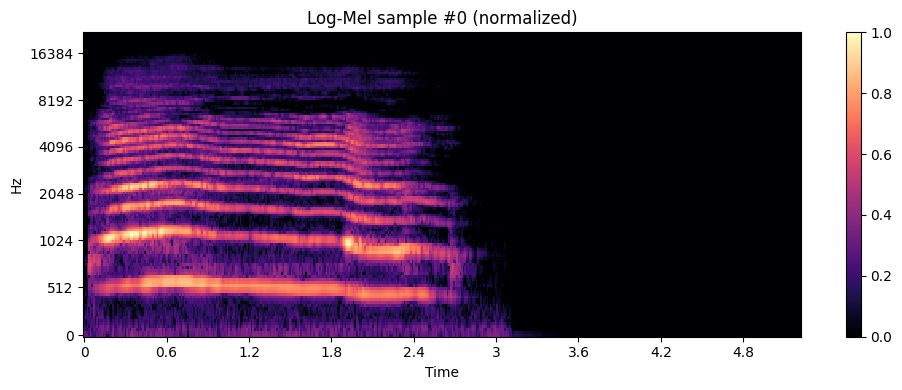

Class: crying_baby


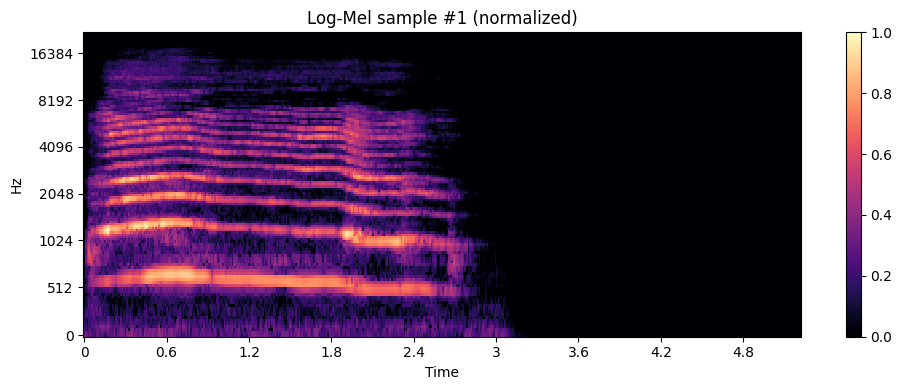

Class: crying_baby


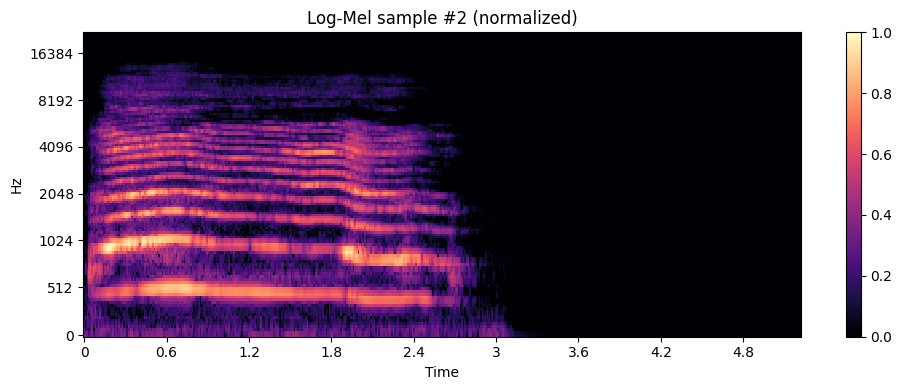

Class: crying_baby


In [32]:
def show_mel_sample(index):
    mel = X_train[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()
    print("Class:", ESCLabels(y_train[index].item()).name)

for i in range(3):
    show_mel_sample(i)

In [33]:
print("y_train shape:", y_train.shape)
print("Etichette uniche:", np.unique(y_train))

# Stampa etichetta di un esempio
for i in range(3):
    print(f"Esempio {i}: label = {y_train[i]}")


y_train shape: torch.Size([1200])
Etichette uniche: [0 1 2 3 4 5 6 7 8 9]
Esempio 0: label = 3
Esempio 1: label = 3
Esempio 2: label = 3


# Spike Encoding

We define now an helper function to visualize the following ecoded spike trains.

In [34]:
def visualize_spike_trains(spike_tensor, sample_idx=0, mel_bin=10):
    """
    Visualizes delta spike encodings with three plots:
    1. Full raster plot of all mel bins
    2. Single mel bin spike train with vertical lines
    3. Density plot showing balance between positive and negative spikes

    Args:
      spike_tensor : torch.Tensor or list
          The delta spike tensor. Expected shape: [batch_size, time_frames, n_mels]
          If from DataLoader, expected to be a list containing tensors
      sample_idx : int
          Index of the sample in the batch to visualize
      mel_bin : int
          Which mel frequency bin to visualize in the spike train plot
    """

    # Check if input is a list (from DataLoader) or direct tensor
    if isinstance(spike_tensor, list):
        spikes = spike_tensor[0].squeeze(-1)[sample_idx].detach().cpu().numpy()
    elif isinstance(spike_tensor, torch.Tensor):
        # If 4D tensor [batch_size, time_frames, n_mels]
        if len(spike_tensor.shape) == 3:
            spikes = spike_tensor.squeeze(-1)[sample_idx, :, :].detach().cpu().numpy()
        else:
            raise ValueError(f"Unexpected spike tensor shape: {spike_tensor.shape}")
    else:
        raise TypeError("spike_tensor must be a torch.Tensor or a list containing tensors")

    if len(spikes.shape) > 2:
        spikes = spikes.squeeze()

    pos_spikes = (spikes > 0).astype(float)
    neg_spikes = (spikes < 0).astype(float)

    plt.figure(figsize=(10, 12))

    # 1. Raster Plot with Inverted Y-axis
    plt.subplot(3, 1, 1)
    plt.imshow(spikes.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
    plt.colorbar(ticks=[-1, 0, 1], label='Spike Type')
    plt.title("Full Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Bin")
    num_mel_bins = spikes.shape[1]
    tick_interval = max(1, num_mel_bins // 7)
    plt.yticks(np.arange(0, num_mel_bins, tick_interval))

    # 2. Single Mel Bin Spike Train with vlines
    plt.subplot(3, 1, 2)
    pos_times = np.where(spikes[:, mel_bin] == 1)[0]
    neg_times = np.where(spikes[:, mel_bin] == -1)[0]
    plt.vlines(pos_times, 0, 1, color='red', linewidth=0.8)
    plt.vlines(neg_times, -1, 0, color='blue', linewidth=0.8)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    plt.title(f"Spike Train for Mel Bin {mel_bin}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike Value")
    plt.grid(False)
    legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Positive Spikes'),
                      plt.Line2D([0], [0], color='blue', lw=2, label='Negative Spikes')]
    plt.legend(handles=legend_elements)

    # 3. Density Plot with Legend
    plt.subplot(3, 1, 3)
    plt.stackplot(np.arange(spikes.shape[0]),
                  pos_spikes.sum(axis=1),
                  -neg_spikes.sum(axis=1),
                  colors=['red', 'blue'])

    plt.legend(['Positive Spikes', 'Negative Spikes'])
    plt.title("Spike Polarity Balance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Spike Count")

    plt.tight_layout()
    plt.show()

## Step Forward

In [35]:
class StepForwardDataset(Dataset):

  """
  Dataset class that applies Step Forward encoding to spectrograms.
  """
  def __init__(self, X, y, threshold=0.05):
    """
    Args:
      X: Tensor of shape [num_samples, n_mels, time_steps, 1]
      y: Tensor of labels [num_samples]
      threshold: Threshold for Step Forward encoding
    """
    self.X = X
    self.y = y
    self.threshold = threshold

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x = self.X[idx].squeeze(-1)  # [n_mels, time_steps]
    y = self.y[idx]

    spike_train = torch.zeros(
        x.shape[1], x.shape[0], dtype=torch.int8
    )  # [time_steps, n_mels]

    # Apply Step Forward encoding to each mel frequency bin
    for mel_idx in range(x.shape[0]):
        spikes, _ = self._encode(x[mel_idx])
        spike_train[:, mel_idx] = torch.from_numpy(spikes)

    return spike_train, y.long()

  def _encode(self, input_signal):
    """
    Step Forward encoding algorithm implementation.

    Args:
        input_signal: 1D array/tensor - input signal to encode
        threshold: float - threshold value for spike generation

    Returns:
        spikes: 1D array - encoded spike train with values {-1, 0, 1}
        base_history: 1D array - history of base values (for debugging/analysis)
    """
    # Convert to numpy if torch tensor
    if isinstance(input_signal, torch.Tensor):
        input_signal = input_signal.numpy()

    L = len(input_signal)
    spikes = np.zeros(L, dtype=np.int8)
    base_history = np.zeros(L)  # Track base evolution

    # Initialize base with first input value
    base = input_signal[0]
    base_history[0] = base

    # Process each timestep starting from index 1
    for i in range(1, L):
        if input_signal[i] > base + self.threshold:
            spikes[i] = 1
            base = base + self.threshold  # Update base upward
        elif input_signal[i] < base - self.threshold:
            spikes[i] = -1
            base = base - self.threshold  # Update base downward
        # else: spikes[i] remains 0

        base_history[i] = base

    return spikes, base_history


In [36]:
sf_train_dataset = StepForwardDataset(
    X_train, y_train,
    threshold=0.05
)

sf_val_dataset = StepForwardDataset(
    X_val, y_val,
    threshold=0.05
)

sf_test_dataset = StepForwardDataset(
    X_test, y_test,
    threshold=0.05
)

sf_train_dataloader = DataLoader(
    dataset=sf_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

sf_val_dataloader = DataLoader(
    dataset=sf_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

sf_test_dataloader = DataLoader(
    dataset=sf_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)


sf_x_batch, sf_y_batch = next(iter(sf_train_dataloader))
print(sf_x_batch.shape)

torch.Size([32, 450, 128])


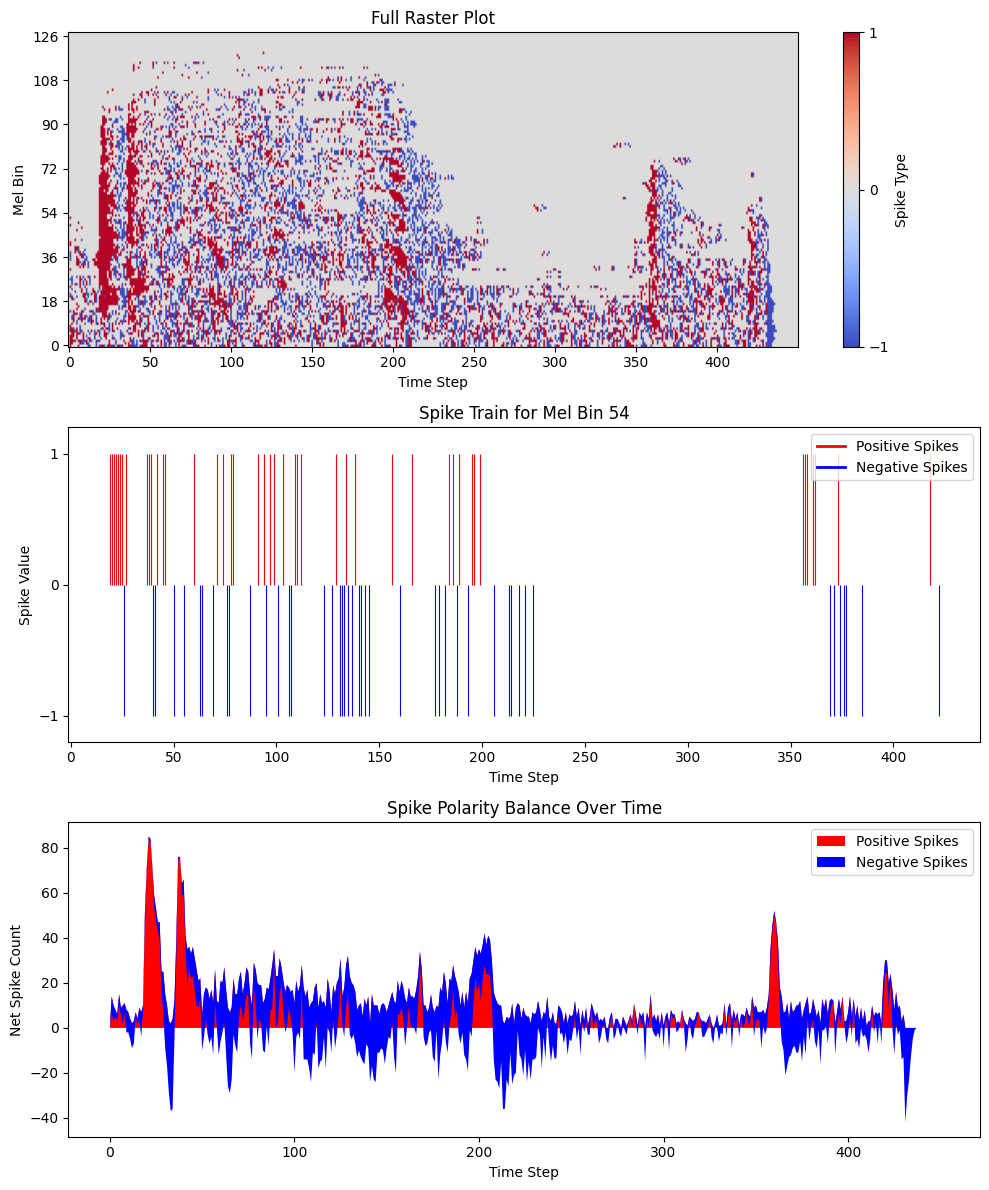

In [37]:
sample_idx = 0
visualize_spike_trains(spike_tensor=sf_x_batch, sample_idx=sample_idx, mel_bin=54)

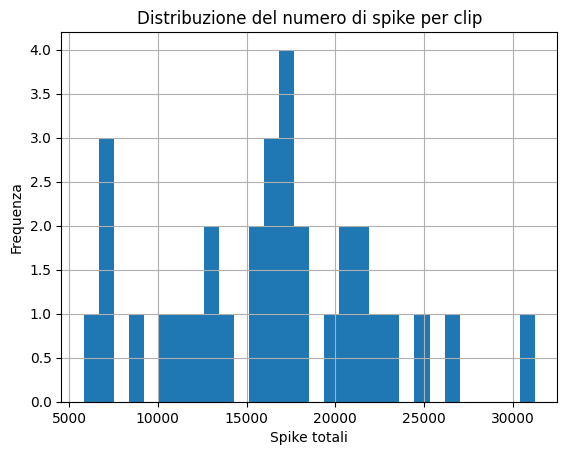

In [38]:
def count_spikes(spike_train):
    return spike_train.abs().sum(dim=[1, 2])  # somma spike su tempo e bande mel

spike_counts = count_spikes(sf_x_batch)
plt.hist(spike_counts.cpu().numpy(), bins=30)
plt.title("Distribuzione del numero di spike per clip")
plt.xlabel("Spike totali")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()

In [39]:
def count_spikes_batch(data):
    """
    Count positive and negative spikes in a single batch

    Args:
        data: torch.Tensor of shape (batch_size, channels, timesteps) or (batch_size, timesteps)

    Returns:
        dict with spike counts for this batch
    """
    # Convert to numpy if it's a torch tensor
    if isinstance(data, torch.Tensor):
        data = data.numpy()

    # Handle different tensor shapes
    if len(data.shape) == 3:  # (batch_size, channels, timesteps)
        # Flatten across batch and channels, keep timesteps
        flattened = data.reshape(-1, data.shape[-1])
    elif len(data.shape) == 2:  # (batch_size, timesteps)
        flattened = data
    else:
        raise ValueError(f"Unexpected data shape: {data.shape}")

    # Count spikes
    positive_spikes = (flattened > 0).sum()
    negative_spikes = (flattened < 0).sum()
    zero_values = (flattened == 0).sum()
    total_values = flattened.size

    return {
        'positive_spikes': int(positive_spikes),
        'negative_spikes': int(negative_spikes),
        'zero_values': int(zero_values),
        'total_values': int(total_values)
    }

def analyze_complete_dataset(dataloader, dataset_name="Dataset"):
    """
    Analyze spikes across all batches in a dataloader

    Args:
        dataloader: PyTorch DataLoader
        dataset_name: Name for the dataset (for display purposes)

    Returns:
        dict with complete spike analysis
    """
    print(f"Analyzing {dataset_name}...")

    total_positive = 0
    total_negative = 0
    total_zeros = 0
    total_values = 0
    batch_results = []

    # Iterate through all batches
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(dataloader, desc=f"Processing {dataset_name}")):
        batch_counts = count_spikes_batch(X_batch)

        # Accumulate totals
        total_positive += batch_counts['positive_spikes']
        total_negative += batch_counts['negative_spikes']
        total_zeros += batch_counts['zero_values']
        total_values += batch_counts['total_values']

        # Store batch results
        batch_results.append({
            'batch_idx': batch_idx,
            'batch_size': X_batch.shape[0],
            **batch_counts
        })

    # Calculate overall statistics
    results = {
        'dataset_name': dataset_name,
        'total_batches': len(batch_results),
        'total_samples': sum([br['batch_size'] for br in batch_results]),
        'total_positive_spikes': total_positive,
        'total_negative_spikes': total_negative,
        'total_zero_values': total_zeros,
        'total_values': total_values,
        'positive_ratio': total_positive / total_values if total_values > 0 else 0,
        'negative_ratio': total_negative / total_values if total_values > 0 else 0,
        'zero_ratio': total_zeros / total_values if total_values > 0 else 0,
        'batch_results': batch_results
    }

    return results

def print_dataset_summary(results):
    """Print a summary of the dataset analysis"""
    print(f"\n{results['dataset_name']} Analysis Results:")
    print("=" * 50)
    print(f"Total batches: {results['total_batches']}")
    print(f"Total samples: {results['total_samples']:,}")
    print(f"Total values analyzed: {results['total_values']:,}")
    print()
    print("Spike Counts:")
    print(f"  Positive spikes: {results['total_positive_spikes']:,}")
    print(f"  Negative spikes: {results['total_negative_spikes']:,}")
    print(f"  Zero values: {results['total_zero_values']:,}")
    print()
    print("Spike Ratios:")
    print(f"  Positive spike ratio: {results['positive_ratio']:.4f} ({results['positive_ratio']*100:.2f}%)")
    print(f"  Negative spike ratio: {results['negative_ratio']:.4f} ({results['negative_ratio']*100:.2f}%)")
    print(f"  Zero ratio: {results['zero_ratio']:.4f} ({results['zero_ratio']*100:.2f}%)")
    print()
    print(f"  Spike density: {(results['total_positive_spikes'] + results['total_negative_spikes']) / results['total_values']:.4f}")


results = analyze_complete_dataset(sf_train_dataloader, dataset_name="StepForward Train")
print_dataset_summary(results)

Analyzing StepForward Train...


Processing StepForward Train: 100%|██████████| 38/38 [00:23<00:00,  1.59it/s]


StepForward Train Analysis Results:
Total batches: 38
Total samples: 1,200
Total values analyzed: 69,120,000

Spike Counts:
  Positive spikes: 9,708,479
  Negative spikes: 10,409,291
  Zero values: 49,002,230

Spike Ratios:
  Positive spike ratio: 0.1405 (14.05%)
  Negative spike ratio: 0.1506 (15.06%)
  Zero ratio: 0.7089 (70.89%)

  Spike density: 0.2911


# SNN Modelling

A single batch of data has shape: \[batch_size, time_frames, n_mels\].

In [40]:
def train_fn(model, train_loader, valid_loader, accuracy, loss_fn, optimizer,
             epochs, patience, path, verbose=True, max_batches=None):
    """
    - Optimized training function with:
    - Mixed precision training
    - Reduced GPU memory usage
    - Progress tracking
    """

    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    counter = 0
    best_val_loss = float('inf')

    # Enable mixed precision training if available
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

    for epoch in tqdm(range(epochs), desc="Epochs"):
        start_time = time.time()

        # Training mode
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc="Train batches", leave=False, total=len(train_loader))):
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            optimizer.zero_grad(set_to_none=True)

            # Use mixed precision where available
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                spk_out, _ = model(X.float())
                acc = accuracy(spk_out, y)
                loss = loss_fn(spk_out, y)
                loss.backward()
                optimizer.step()

            train_acc += acc.item()
            train_loss += loss.item()

            # Free up memory
            del X, y, spk_out, loss, acc

        # Calculate average metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc_avg = train_acc / len(train_loader)
        train_loss_list.append(train_loss_avg)
        train_acc_list.append(train_acc_avg)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(valid_loader):
                X = X.squeeze().to(device)
                y = y.squeeze().long().to(device)

                # Forward pass with reduced memory usage
                if scaler:
                    with torch.cuda.amp.autocast():
                        spk_out, _ = model(X.float())
                        acc = accuracy(spk_out, y)
                        loss = loss_fn(spk_out, y)
                else:
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                val_acc += acc.item()
                val_loss += loss.item()

                # Free up memory
                del X, y, spk_out, loss, acc

        # Calculate validation metrics
        val_loss_avg = val_loss / len(valid_loader)
        val_acc_avg = val_acc / len(valid_loader)
        val_loss_list.append(val_loss_avg)
        val_acc_list.append(val_acc_avg)

        # Early stopping logic
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            counter = 0
            if path:
                #torch.save(model.state_dict(), path)
                pass
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered")
            break

        torch.cuda.empty_cache()
        end_time = time.time()

        if verbose:
            print(f"\nEpoch {epoch+1}/{epochs} - {int(end_time-start_time)}s - "
                  f"loss: {train_loss_avg:.4f} - acc: {train_acc_avg:.4f} - "
                  f"val_loss: {val_loss_avg:.4f} - val_acc: {val_acc_avg:.4f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, precision_score, recall_score

def evaluate_model_comprehensive(model, dataloader, class_names, device):
    """
    Comprehensive evaluation function that computes accuracy, F1, precision, and recall.
    Now handles zero-division gracefully and reports classes with no predictions.
    Enhanced confusion matrix shows percentages for each cell.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            spk_out, _ = model(X.float())
            spk_sum = spk_out.sum(dim=0)  # [batch_size, num_classes]
            preds = torch.argmax(spk_sum, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Identify classes never predicted
    missing = set(range(len(class_names))) - set(np.unique(all_preds))
    if missing:
        print("WARNING: The following classes were never predicted:",
              [class_names[i] for i in sorted(missing)])

    # Calculate accuracy
    accuracy = (all_preds == all_labels).mean()

    # Macro and weighted metrics with zero_division=0
    f1_macro    = f1_score(all_labels, all_preds, average='macro',    zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    precision_macro    = precision_score(all_labels, all_preds, average='macro',    zero_division=0)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)

    recall_macro    = recall_score(all_labels, all_preds, average='macro',    zero_division=0)
    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Per-class metrics
    f1_per_class        = f1_score(all_labels, all_preds, average=None, zero_division=0)
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class    = recall_score(all_labels, all_preds, average=None, zero_division=0)

    # Print summary
    print("="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

    print("MACRO AVERAGES:")
    print(f"  F1-Score   : {f1_macro:.4f}")
    print(f"  Precision  : {precision_macro:.4f}")
    print(f"  Recall     : {recall_macro:.4f}\n")

    print("WEIGHTED AVERAGES:")
    print(f"  F1-Score   : {f1_weighted:.4f}")
    print(f"  Precision  : {precision_weighted:.4f}")
    print(f"  Recall     : {recall_weighted:.4f}\n")

    print("PER-CLASS METRICS:")
    print("-" * 60)
    print(f"{'Class':<15} {'F1':<8} {'Precision':<10} {'Recall':<8}")
    print("-" * 60)
    for i, name in enumerate(class_names):
        print(f"{name:<15} "
              f"{f1_per_class[i]:<8.4f} "
              f"{precision_per_class[i]:<10.4f} "
              f"{recall_per_class[i]:<8.4f}")

    # Detailed report
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4,
        zero_division=0
    ))

    # Enhanced Confusion Matrix with percentages
    cm = confusion_matrix(all_labels, all_preds)

    # Create percentage matrix (normalize by row - true class)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    # Handle division by zero (classes with no samples)
    cm_percentage = np.nan_to_num(cm_percentage)

    # Create the enhanced confusion matrix plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Standard confusion matrix with counts
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp1.plot(ax=ax1, cmap="Blues", xticks_rotation=45)
    ax1.set_title("Confusion Matrix - Counts", fontsize=14, fontweight='bold')

    # Plot 2: Enhanced confusion matrix with percentages
    im = ax2.imshow(cm_percentage, interpolation='nearest', cmap='Blues')
    ax2.figure.colorbar(im, ax=ax2)
    ax2.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=class_names, yticklabels=class_names,
            title="Confusion Matrix - Percentages (Row-wise)",
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text annotations with both count and percentage
    fmt = '.1f'
    thresh = cm_percentage.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Display both count and percentage
            text = f'{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)'
            ax2.text(j, i, text,
                    ha="center", va="center",
                    color="white" if cm_percentage[i, j] > thresh else "black",
                    fontsize=10, fontweight='bold')

    ax2.set_title("Confusion Matrix - Counts & Percentages", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Additional analysis: Print per-class accuracy breakdown
    print("\n" + "="*60)
    print("PER-CLASS ACCURACY BREAKDOWN")
    print("="*60)
    print(f"{'True Class':<15} {'Correct':<8} {'Total':<8} {'Accuracy':<10}")
    print("-" * 60)

    for i, name in enumerate(class_names):
        correct = cm[i, i]  # Diagonal elements
        total = cm[i, :].sum()  # Total samples for this true class
        class_accuracy = correct / total * 100 if total > 0 else 0
        print(f"{name:<15} {correct:<8} {total:<8} {class_accuracy:<10.2f}%")

    # Create a third plot showing only the diagonal accuracy
    fig, ax3 = plt.subplots(figsize=(10, 6))
    class_accuracies = []
    for i in range(len(class_names)):
        correct = cm[i, i]
        total = cm[i, :].sum()
        acc = correct / total * 100 if total > 0 else 0
        class_accuracies.append(acc)

    bars = ax3.bar(class_names, class_accuracies, color='skyblue', alpha=0.7)
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax3.set_ylim(0, 100)
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Add horizontal line for overall accuracy
    ax3.axhline(y=accuracy*100, color='red', linestyle='--', alpha=0.7,
                label=f'Overall Accuracy: {accuracy*100:.1f}%')
    ax3.legend()

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_per_class': f1_per_class,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'confusion_matrix': cm,
        'confusion_matrix_percentage': cm_percentage,
        'per_class_accuracy': class_accuracies
    }

## Simple SNN

In [121]:
class SNNClassifier(torch.nn.Module):
    def __init__(
        self,
        n_mels,
        hidden_sizes,
        num_classes,
        surr_grad,
        learn_thr=True,
        learn_beta=True,
    ):
        super(SNNClassifier, self).__init__()
        self.n_mels = n_mels
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # Layer 1: Input to Hidden 1
        self.fc1 = torch.nn.Linear(n_mels, self.hidden_sizes[0])
        self.lif1 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[0],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 2: Hidden 1 to Hidden 2
        self.fc2 = torch.nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1])
        self.lif2 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[1],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 3: Hidden 2 to Hidden 3
        self.fc3 = torch.nn.Linear(self.hidden_sizes[1], self.hidden_sizes[2])
        self.lif3 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[2],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Output Layer
        self.fc_out = torch.nn.Linear(self.hidden_sizes[2], num_classes)
        self.lif_out = snn.Leaky(
            beta=torch.full((num_classes,), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism='zero',
        )

    def forward(self, x):
        batch_size, time_steps, _ = x.shape

        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_rec = []
        mem_rec = []

        for step in range(time_steps):
            x_t = x[:, step, :]

            cur1 = self.fc1(x_t)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            cur_out = self.fc_out(spk3)
            spk_out, mem_out = self.lif_out(cur_out, mem_out)

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

In [122]:
hidden_sizes = [128, 128, 128]
num_classes = 10

snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 128]                 16,512
├─Leaky: 1-6                             [32, 128]                 129
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  11
Total params: 51,224
Trainable params: 51,224
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.42

## Simple SNN Training

In [123]:
patience = 30
num_epochs = 100
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=sf_train_dataloader,
    valid_loader=sf_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True
)

Train batches:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipython-input-99-3213160476.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches: 100%|██████████| 38/38 [01:31<00:00,  2.35s/it]
                                                              /tmp/ipython-input-99-3213160476.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   1%|          | 1/100 [01:36<2:39:22, 96.59s/it]


Epoch 1/100 - 96s - loss: 2.3026 - acc: 0.1003 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [03:12<2:36:42, 95.95s/it]


Epoch 2/100 - 95s - loss: 2.3070 - acc: 0.1283 - val_loss: 2.3470 - val_acc: 0.1250



Epochs:   3%|▎         | 3/100 [04:47<2:35:00, 95.88s/it]


Epoch 3/100 - 95s - loss: 2.3106 - acc: 0.1620 - val_loss: 2.2313 - val_acc: 0.1146



Epochs:   4%|▍         | 4/100 [06:23<2:33:07, 95.71s/it]


Epoch 4/100 - 95s - loss: 2.2607 - acc: 0.1957 - val_loss: 2.2373 - val_acc: 0.1771



Epochs:   5%|▌         | 5/100 [07:59<2:31:49, 95.89s/it]


Epoch 5/100 - 96s - loss: 2.1984 - acc: 0.2212 - val_loss: 2.2297 - val_acc: 0.1667



Epochs:   6%|▌         | 6/100 [09:35<2:30:03, 95.78s/it]


Epoch 6/100 - 95s - loss: 2.1161 - acc: 0.2566 - val_loss: 2.0208 - val_acc: 0.2917



Epochs:   7%|▋         | 7/100 [11:10<2:28:30, 95.81s/it]


Epoch 7/100 - 95s - loss: 1.7931 - acc: 0.3717 - val_loss: 2.0006 - val_acc: 0.3542



Epochs:   8%|▊         | 8/100 [12:46<2:26:53, 95.80s/it]


Epoch 8/100 - 95s - loss: 1.6290 - acc: 0.4104 - val_loss: 1.5367 - val_acc: 0.4479



Epochs:   9%|▉         | 9/100 [14:22<2:25:21, 95.84s/it]


Epoch 9/100 - 95s - loss: 1.5793 - acc: 0.4219 - val_loss: 1.6821 - val_acc: 0.3021



Epochs:  10%|█         | 10/100 [15:58<2:23:46, 95.85s/it]


Epoch 10/100 - 95s - loss: 2.1567 - acc: 0.4079 - val_loss: 1.7113 - val_acc: 0.5000



Epochs:  11%|█         | 11/100 [17:34<2:22:03, 95.78s/it]


Epoch 11/100 - 95s - loss: 1.4667 - acc: 0.4548 - val_loss: 1.4556 - val_acc: 0.3854



Epochs:  12%|█▏        | 12/100 [19:09<2:20:29, 95.79s/it]


Epoch 12/100 - 95s - loss: 1.4187 - acc: 0.4729 - val_loss: 1.6967 - val_acc: 0.5000



Epochs:  13%|█▎        | 13/100 [20:46<2:19:03, 95.90s/it]


Epoch 13/100 - 96s - loss: 1.4999 - acc: 0.5082 - val_loss: 2.0035 - val_acc: 0.4583



Epochs:  14%|█▍        | 14/100 [22:21<2:17:25, 95.88s/it]


Epoch 14/100 - 95s - loss: 1.5626 - acc: 0.4926 - val_loss: 1.6294 - val_acc: 0.4375



Epochs:  15%|█▌        | 15/100 [23:57<2:15:48, 95.87s/it]


Epoch 15/100 - 95s - loss: 1.4791 - acc: 0.4951 - val_loss: 1.9702 - val_acc: 0.3125



Epochs:  16%|█▌        | 16/100 [25:33<2:14:19, 95.94s/it]


Epoch 16/100 - 96s - loss: 1.6285 - acc: 0.4868 - val_loss: 1.5879 - val_acc: 0.5208



Epochs:  17%|█▋        | 17/100 [27:10<2:12:53, 96.06s/it]


Epoch 17/100 - 96s - loss: 1.3203 - acc: 0.5444 - val_loss: 1.5789 - val_acc: 0.5208



Epochs:  18%|█▊        | 18/100 [28:45<2:11:05, 95.93s/it]


Epoch 18/100 - 95s - loss: 1.1854 - acc: 0.6044 - val_loss: 1.5251 - val_acc: 0.5521



Epochs:  19%|█▉        | 19/100 [30:21<2:09:18, 95.78s/it]


Epoch 19/100 - 95s - loss: 1.3072 - acc: 0.5822 - val_loss: 1.7334 - val_acc: 0.5312



Epochs:  20%|██        | 20/100 [31:56<2:07:36, 95.71s/it]


Epoch 20/100 - 95s - loss: 1.3801 - acc: 0.5888 - val_loss: 1.4750 - val_acc: 0.5625



Epochs:  21%|██        | 21/100 [33:32<2:06:04, 95.75s/it]


Epoch 21/100 - 95s - loss: 1.2255 - acc: 0.5987 - val_loss: 1.5109 - val_acc: 0.5417



Epochs:  22%|██▏       | 22/100 [35:08<2:04:23, 95.69s/it]


Epoch 22/100 - 95s - loss: 1.5734 - acc: 0.6225 - val_loss: 1.9564 - val_acc: 0.5417



Epochs:  23%|██▎       | 23/100 [36:44<2:02:49, 95.70s/it]


Epoch 23/100 - 95s - loss: 1.5981 - acc: 0.6390 - val_loss: 1.6795 - val_acc: 0.5729



Epochs:  24%|██▍       | 24/100 [38:19<2:01:18, 95.76s/it]


Epoch 24/100 - 95s - loss: 1.9216 - acc: 0.6299 - val_loss: 1.9676 - val_acc: 0.5417



Epochs:  25%|██▌       | 25/100 [39:56<2:00:00, 96.00s/it]


Epoch 25/100 - 96s - loss: 1.3751 - acc: 0.6678 - val_loss: 2.3664 - val_acc: 0.6146



Epochs:  26%|██▌       | 26/100 [41:32<1:58:15, 95.88s/it]


Epoch 26/100 - 95s - loss: 1.2212 - acc: 0.6875 - val_loss: 1.8018 - val_acc: 0.5729



Epochs:  27%|██▋       | 27/100 [43:07<1:56:34, 95.81s/it]


Epoch 27/100 - 95s - loss: 1.3304 - acc: 0.6998 - val_loss: 1.6434 - val_acc: 0.6146



Epochs:  28%|██▊       | 28/100 [44:43<1:55:03, 95.89s/it]


Epoch 28/100 - 96s - loss: 1.3457 - acc: 0.7105 - val_loss: 1.3641 - val_acc: 0.6458



Epochs:  29%|██▉       | 29/100 [46:19<1:53:30, 95.92s/it]


Epoch 29/100 - 95s - loss: 0.9586 - acc: 0.7368 - val_loss: 1.3122 - val_acc: 0.6771



Epochs:  30%|███       | 30/100 [47:55<1:51:59, 95.99s/it]


Epoch 30/100 - 96s - loss: 0.9107 - acc: 0.7442 - val_loss: 1.7868 - val_acc: 0.6979



Epochs:  31%|███       | 31/100 [49:32<1:50:33, 96.14s/it]


Epoch 31/100 - 96s - loss: 1.3106 - acc: 0.7484 - val_loss: 2.0469 - val_acc: 0.6354



Epochs:  32%|███▏      | 32/100 [51:08<1:48:54, 96.10s/it]


Epoch 32/100 - 95s - loss: 1.0581 - acc: 0.7377 - val_loss: 1.2744 - val_acc: 0.7188



Epochs:  33%|███▎      | 33/100 [52:44<1:47:17, 96.08s/it]


Epoch 33/100 - 96s - loss: 0.8233 - acc: 0.7780 - val_loss: 1.7368 - val_acc: 0.6458



Epochs:  34%|███▍      | 34/100 [54:19<1:45:29, 95.91s/it]


Epoch 34/100 - 95s - loss: 0.8075 - acc: 0.7829 - val_loss: 1.4049 - val_acc: 0.6979



Epochs:  35%|███▌      | 35/100 [55:55<1:43:52, 95.89s/it]


Epoch 35/100 - 95s - loss: 0.8001 - acc: 0.7681 - val_loss: 1.4587 - val_acc: 0.6562



Epochs:  36%|███▌      | 36/100 [57:31<1:42:19, 95.93s/it]


Epoch 36/100 - 96s - loss: 0.7622 - acc: 0.7714 - val_loss: 1.3323 - val_acc: 0.6250



Epochs:  37%|███▋      | 37/100 [59:07<1:40:42, 95.91s/it]


Epoch 37/100 - 95s - loss: 0.7228 - acc: 0.7878 - val_loss: 1.3496 - val_acc: 0.6667



Epochs:  38%|███▊      | 38/100 [1:00:43<1:39:04, 95.87s/it]


Epoch 38/100 - 95s - loss: 0.7357 - acc: 0.7854 - val_loss: 1.0670 - val_acc: 0.6979



Epochs:  39%|███▉      | 39/100 [1:02:19<1:37:22, 95.78s/it]


Epoch 39/100 - 95s - loss: 0.6968 - acc: 0.8002 - val_loss: 1.5697 - val_acc: 0.6562



Epochs:  40%|████      | 40/100 [1:03:55<1:35:50, 95.85s/it]


Epoch 40/100 - 96s - loss: 0.6716 - acc: 0.7993 - val_loss: 1.2274 - val_acc: 0.7188



Epochs:  41%|████      | 41/100 [1:05:31<1:34:21, 95.97s/it]


Epoch 41/100 - 96s - loss: 0.5355 - acc: 0.8257 - val_loss: 1.7308 - val_acc: 0.6667



Epochs:  42%|████▏     | 42/100 [1:07:07<1:32:43, 95.92s/it]


Epoch 42/100 - 95s - loss: 0.5210 - acc: 0.8487 - val_loss: 1.4582 - val_acc: 0.6771



Epochs:  43%|████▎     | 43/100 [1:08:42<1:31:04, 95.87s/it]


Epoch 43/100 - 95s - loss: 0.4806 - acc: 0.8405 - val_loss: 1.2997 - val_acc: 0.7292



Epochs:  44%|████▍     | 44/100 [1:10:18<1:29:27, 95.85s/it]


Epoch 44/100 - 95s - loss: 0.4672 - acc: 0.8528 - val_loss: 1.5153 - val_acc: 0.6979



Epochs:  45%|████▌     | 45/100 [1:11:55<1:28:04, 96.09s/it]


Epoch 45/100 - 96s - loss: 0.4281 - acc: 0.8627 - val_loss: 1.9545 - val_acc: 0.6979



Epochs:  46%|████▌     | 46/100 [1:13:31<1:26:30, 96.12s/it]


Epoch 46/100 - 96s - loss: 0.4778 - acc: 0.8594 - val_loss: 1.3961 - val_acc: 0.7083



Epochs:  47%|████▋     | 47/100 [1:15:07<1:24:51, 96.07s/it]


Epoch 47/100 - 95s - loss: 0.5041 - acc: 0.8684 - val_loss: 1.8575 - val_acc: 0.6562



Epochs:  48%|████▊     | 48/100 [1:16:43<1:23:08, 95.94s/it]


Epoch 48/100 - 95s - loss: 0.4716 - acc: 0.8717 - val_loss: 1.3172 - val_acc: 0.6771



Epochs:  49%|████▉     | 49/100 [1:18:19<1:21:36, 96.01s/it]


Epoch 49/100 - 96s - loss: 0.4076 - acc: 0.8824 - val_loss: 1.5018 - val_acc: 0.7396



Epochs:  50%|█████     | 50/100 [1:19:55<1:20:01, 96.02s/it]


Epoch 50/100 - 96s - loss: 0.3619 - acc: 0.8964 - val_loss: 1.7898 - val_acc: 0.7396



Epochs:  51%|█████     | 51/100 [1:21:31<1:18:23, 95.99s/it]


Epoch 51/100 - 95s - loss: 0.3985 - acc: 0.8882 - val_loss: 1.7555 - val_acc: 0.6771



Epochs:  52%|█████▏    | 52/100 [1:23:07<1:16:50, 96.05s/it]


Epoch 52/100 - 96s - loss: 0.3596 - acc: 0.8947 - val_loss: 1.3450 - val_acc: 0.6562



Epochs:  53%|█████▎    | 53/100 [1:24:44<1:15:22, 96.23s/it]


Epoch 53/100 - 96s - loss: 0.3431 - acc: 0.9079 - val_loss: 1.7428 - val_acc: 0.6562



Epochs:  54%|█████▍    | 54/100 [1:26:20<1:13:44, 96.19s/it]


Epoch 54/100 - 96s - loss: 0.3419 - acc: 0.9071 - val_loss: 1.2666 - val_acc: 0.7604



Epochs:  55%|█████▌    | 55/100 [1:27:57<1:12:18, 96.41s/it]


Epoch 55/100 - 96s - loss: 0.3506 - acc: 0.9038 - val_loss: 1.3838 - val_acc: 0.7083



Epochs:  56%|█████▌    | 56/100 [1:29:34<1:10:50, 96.61s/it]


Epoch 56/100 - 97s - loss: 0.2853 - acc: 0.9211 - val_loss: 1.3412 - val_acc: 0.6979



Epochs:  57%|█████▋    | 57/100 [1:31:11<1:09:27, 96.91s/it]


Epoch 57/100 - 97s - loss: 0.2885 - acc: 0.9186 - val_loss: 1.4557 - val_acc: 0.6667



Epochs:  58%|█████▊    | 58/100 [1:32:48<1:07:50, 96.92s/it]


Epoch 58/100 - 96s - loss: 0.2775 - acc: 0.9202 - val_loss: 1.2980 - val_acc: 0.7500



Epochs:  59%|█████▉    | 59/100 [1:34:24<1:06:05, 96.73s/it]


Epoch 59/100 - 96s - loss: 0.2871 - acc: 0.9211 - val_loss: 1.4254 - val_acc: 0.7812



Epochs:  60%|██████    | 60/100 [1:36:01<1:04:24, 96.60s/it]


Epoch 60/100 - 96s - loss: 0.3310 - acc: 0.9095 - val_loss: 1.7857 - val_acc: 0.6562



Epochs:  61%|██████    | 61/100 [1:37:38<1:02:58, 96.89s/it]


Epoch 61/100 - 97s - loss: 0.2988 - acc: 0.9095 - val_loss: 1.3159 - val_acc: 0.7500



Epochs:  62%|██████▏   | 62/100 [1:39:15<1:01:20, 96.86s/it]


Epoch 62/100 - 96s - loss: 0.3604 - acc: 0.8947 - val_loss: 2.1538 - val_acc: 0.6667



Epochs:  63%|██████▎   | 63/100 [1:40:52<59:44, 96.88s/it]  


Epoch 63/100 - 96s - loss: 0.3161 - acc: 0.9202 - val_loss: 1.2895 - val_acc: 0.7604



Epochs:  64%|██████▍   | 64/100 [1:42:29<58:13, 97.04s/it]


Epoch 64/100 - 97s - loss: 0.3375 - acc: 0.9038 - val_loss: 1.0875 - val_acc: 0.8021



Epochs:  65%|██████▌   | 65/100 [1:44:07<56:41, 97.20s/it]


Epoch 65/100 - 97s - loss: 0.4821 - acc: 0.8824 - val_loss: 1.7620 - val_acc: 0.7396



Epochs:  66%|██████▌   | 66/100 [1:45:44<55:01, 97.11s/it]


Epoch 66/100 - 96s - loss: 0.3936 - acc: 0.8906 - val_loss: 1.3390 - val_acc: 0.7292



Epochs:  67%|██████▋   | 67/100 [1:47:21<53:24, 97.11s/it]


Epoch 67/100 - 97s - loss: 0.2140 - acc: 0.9342 - val_loss: 1.3380 - val_acc: 0.7396



Epochs:  67%|██████▋   | 67/100 [1:48:58<53:40, 97.59s/it]

Early stopping triggered


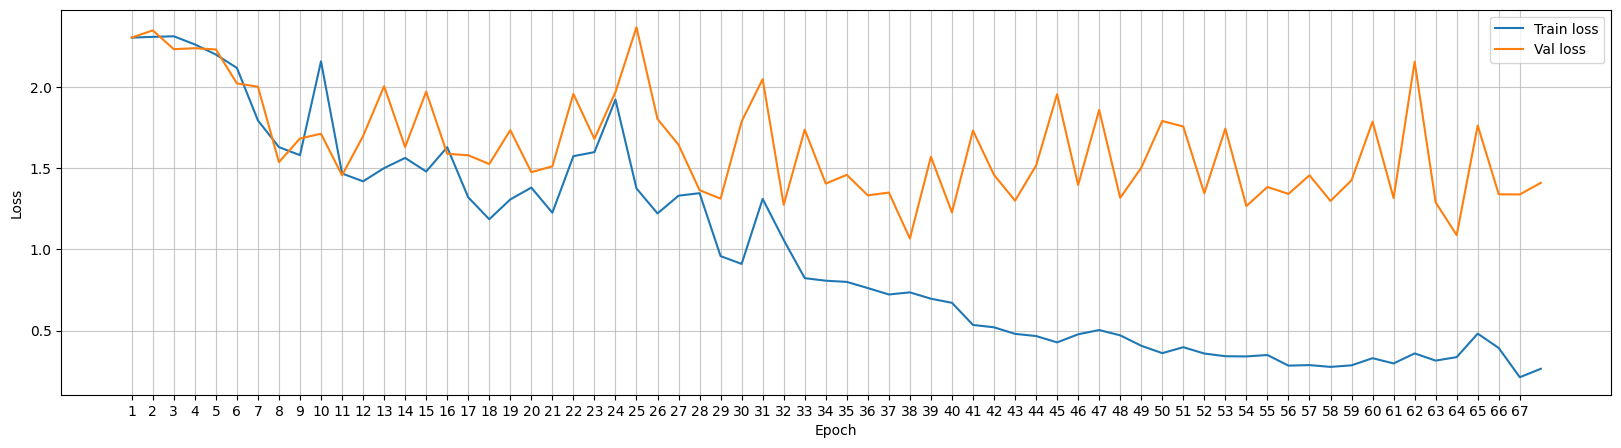

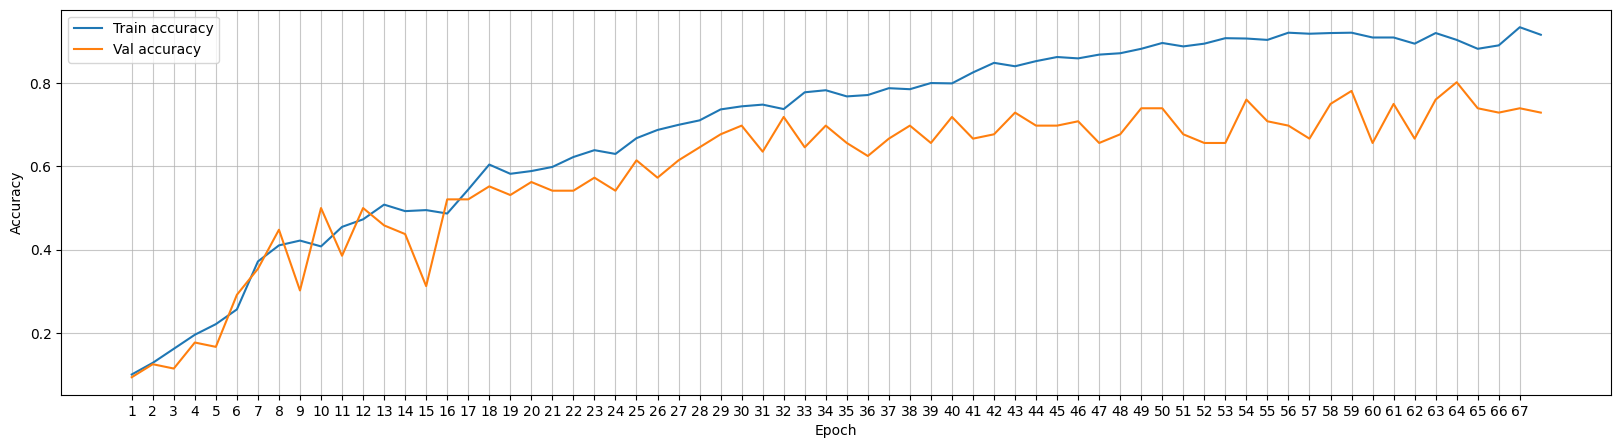

In [124]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.7875 (78.75%)

MACRO AVERAGES:
  F1-Score   : 0.7798
  Precision  : 0.8261
  Recall     : 0.7875

WEIGHTED AVERAGES:
  F1-Score   : 0.7798
  Precision  : 0.8261
  Recall     : 0.7875

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.8750   0.8750     0.8750  
clock_tick      0.7368   0.6364     0.8750  
crackling_fire  0.8421   0.7273     1.0000  
crying_baby     0.8889   0.8000     1.0000  
dog             0.6667   1.0000     0.5000  
helicopter      0.7692   1.0000     0.6250  
rain            0.7059   0.6667     0.7500  
rooster         0.6667   1.0000     0.5000  
sea_waves       0.8235   0.7778     0.8750  
sneezing        0.8235   0.7778     0.8750  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.8750    0.8750    0.8750 

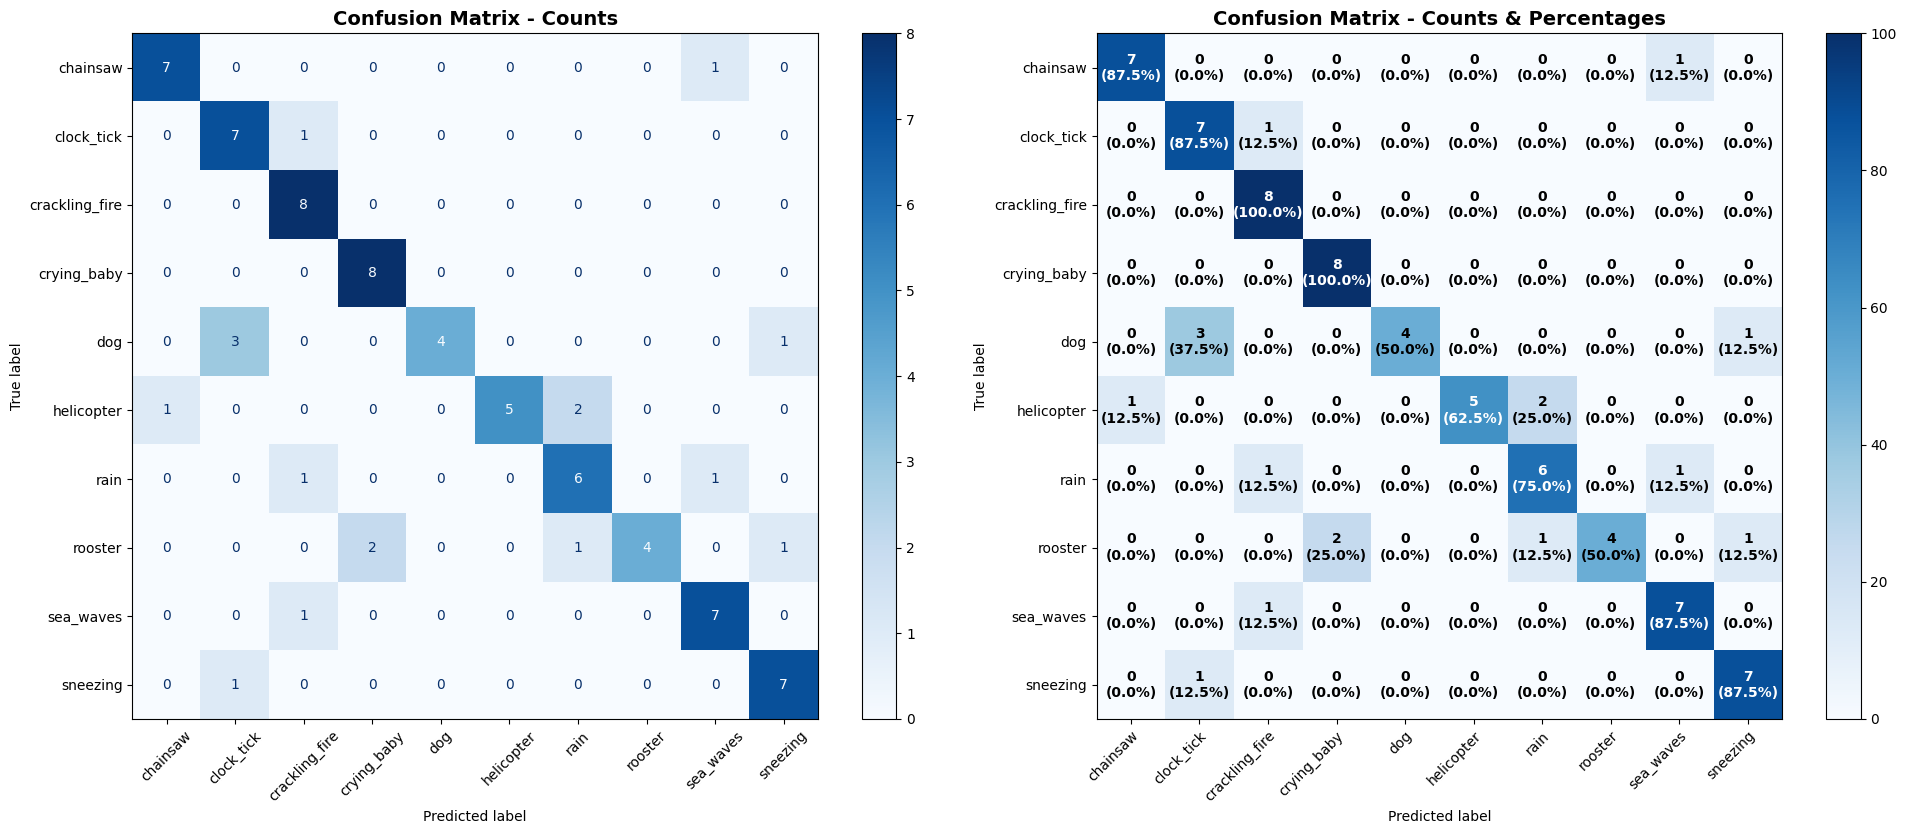


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        7        8        87.50     %
clock_tick      7        8        87.50     %
crackling_fire  8        8        100.00    %
crying_baby     8        8        100.00    %
dog             4        8        50.00     %
helicopter      5        8        62.50     %
rain            6        8        75.00     %
rooster         4        8        50.00     %
sea_waves       7        8        87.50     %
sneezing        7        8        87.50     %


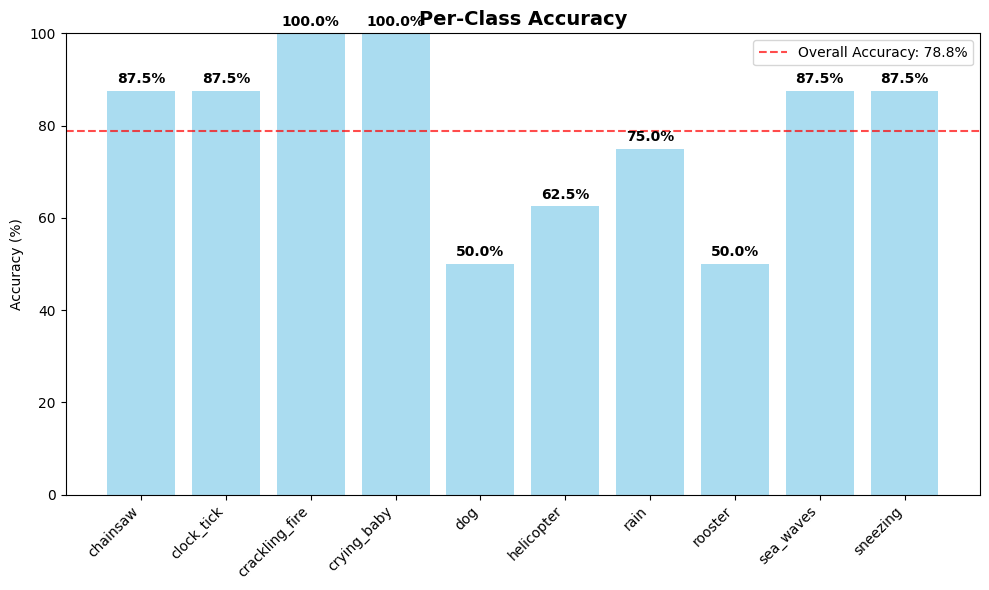

In [125]:
class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]

results = evaluate_model_comprehensive(snn_classifier, sf_test_dataloader, class_names, device)

## Convolutional SNN (C-SNN)

In [56]:
class C_SNN(torch.nn.Module):
    def __init__(
        self,
        surr_grad,
        n_mels: int = 128,
        num_classes: int = 10,
        conv_channels1: int = 8,
        kernel_size: int = 3,
        pool_kernel: int = 2,
        dropout_rate: float = 0.15
    ):
        super().__init__()
        self.surr_grad = surr_grad

        # --- First Spiking Convolutional Block ---
        self.conv1 = torch.nn.Conv1d(
            in_channels=1,
            out_channels=conv_channels1,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            bias=False,
        )
        self.lif1 = snn.Leaky(
            beta=0.9,
            threshold=1.0,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=surr_grad
        )
        self.pool1 = torch.nn.MaxPool1d(kernel_size=pool_kernel)

        # --- Second Spiking Convolutional Block ---
        """
        self.conv2 = torch.nn.Conv1d(
            in_channels=conv_channels1,
            out_channels=conv_channels2,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            bias=False,
        )
        self.lif2 = snn.Leaky(
            beta=0.9,
            threshold=1.0,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=surr_grad
        )
        self.pool2 = torch.nn.MaxPool1d(kernel_size=pool_kernel)
        """

        # --- Fully Connected Layer ---
        freq_after_pool = n_mels // pool_kernel
        self.flattened_size = conv_channels1 * freq_after_pool

        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.fc1 = torch.nn.Linear(self.flattened_size, num_classes, bias=False)
        self.lif_out = snn.Leaky(
            beta=0.9,
            threshold=1.0,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=surr_grad
        )

    def forward(self, spikes: torch.Tensor):
        """
        spikes: [batch_size, time_steps, n_mels]
        Returns:
            spk_rec: [time_steps, batch_size, num_classes]
            mem_rec: [time_steps, batch_size, num_classes]
        """
        B, T, F = spikes.shape

        mem1 = self.lif1.init_leaky()
        # mem2 = self.lif2.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_rec = []
        mem_rec = []

        spikes_tm = spikes.permute(1, 0, 2)  # [T, B, F]

        for t in range(T):
            x_t = spikes_tm[t].unsqueeze(1)  # [B, 1, F]

            # --- Conv Block 1 ---
            x = self.conv1(x_t)
            spk1, mem1 = self.lif1(x, mem1)
            x = self.pool1(spk1)

            # --- Conv Block 2 ---
            """
            x = self.conv2(x)
            spk2, mem2 = self.lif2(x, mem2)
            x = self.pool2(spk2)
            """

            # --- Flatten + FC ---
            x = x.view(B, -1)
            x = self.dropout(x)
            x = self.fc1(x)
            spk_out, mem_out = self.lif_out(x, mem_out)

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        spk_rec = torch.stack(spk_rec, dim=0)
        mem_rec = torch.stack(mem_rec, dim=0)

        return spk_rec, mem_rec

In [57]:
c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=8,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)


summary(c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
C_SNN                                    [1, 32, 10]               --
├─Conv1d: 1-1                            [32, 8, 128]              24
├─Leaky: 1-2                             [32, 8, 128]              2
├─MaxPool1d: 1-3                         [32, 8, 64]               --
├─Dropout: 1-4                           [32, 512]                 --
├─Linear: 1-5                            [32, 10]                  5,120
├─Leaky: 1-6                             [32, 10]                  2
Total params: 5,148
Trainable params: 5,148
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.26
Input size (MB): 0.02
Forward/backward pass size (MB): 0.53
Params size (MB): 0.02
Estimated Total Size (MB): 0.57

## CSNN Training

In [58]:
patience = 30
num_epochs = 100
optimizer = torch.optim.Adam(c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=c_snn_model,
    train_loader=sf_train_dataloader,
    valid_loader=sf_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

Train batches:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipython-input-40-3213160476.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches: 100%|██████████| 38/38 [00:49<00:00,  1.24s/it]
                                                              /tmp/ipython-input-40-3213160476.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   1%|          | 1/100 [00:52<1:26:34, 52.46s/it]


Epoch 1/100 - 52s - loss: 2.5089 - acc: 0.1225 - val_loss: 2.2659 - val_acc: 0.1146



Epochs:   2%|▏         | 2/100 [01:44<1:25:10, 52.15s/it]


Epoch 2/100 - 51s - loss: 2.2770 - acc: 0.1423 - val_loss: 2.2024 - val_acc: 0.1562



Epochs:   3%|▎         | 3/100 [02:36<1:24:09, 52.06s/it]


Epoch 3/100 - 51s - loss: 2.2038 - acc: 0.1916 - val_loss: 2.1347 - val_acc: 0.2188



Epochs:   4%|▍         | 4/100 [03:28<1:23:12, 52.01s/it]


Epoch 4/100 - 51s - loss: 2.1054 - acc: 0.2196 - val_loss: 2.0455 - val_acc: 0.2188



Epochs:   5%|▌         | 5/100 [04:19<1:22:06, 51.85s/it]


Epoch 5/100 - 51s - loss: 2.0362 - acc: 0.2451 - val_loss: 1.9537 - val_acc: 0.2708



Epochs:   6%|▌         | 6/100 [05:11<1:21:14, 51.86s/it]


Epoch 6/100 - 51s - loss: 1.9298 - acc: 0.3059 - val_loss: 1.8292 - val_acc: 0.3125



Epochs:   7%|▋         | 7/100 [06:03<1:20:25, 51.88s/it]


Epoch 7/100 - 51s - loss: 1.8089 - acc: 0.3396 - val_loss: 1.8683 - val_acc: 0.3542



Epochs:   8%|▊         | 8/100 [06:56<1:19:57, 52.14s/it]


Epoch 8/100 - 52s - loss: 1.7212 - acc: 0.3873 - val_loss: 1.6242 - val_acc: 0.4271



Epochs:   9%|▉         | 9/100 [07:48<1:19:02, 52.11s/it]


Epoch 9/100 - 52s - loss: 1.6083 - acc: 0.4317 - val_loss: 1.6541 - val_acc: 0.4271



Epochs:  10%|█         | 10/100 [08:40<1:18:21, 52.24s/it]


Epoch 10/100 - 52s - loss: 1.5087 - acc: 0.4860 - val_loss: 1.5512 - val_acc: 0.4479



Epochs:  11%|█         | 11/100 [09:32<1:17:10, 52.03s/it]


Epoch 11/100 - 51s - loss: 1.4178 - acc: 0.5148 - val_loss: 1.5610 - val_acc: 0.4479



Epochs:  12%|█▏        | 12/100 [10:25<1:16:45, 52.33s/it]


Epoch 12/100 - 53s - loss: 1.3426 - acc: 0.5526 - val_loss: 1.5063 - val_acc: 0.5104



Epochs:  13%|█▎        | 13/100 [11:17<1:15:51, 52.32s/it]


Epoch 13/100 - 52s - loss: 1.2688 - acc: 0.5617 - val_loss: 1.5403 - val_acc: 0.5000



Epochs:  14%|█▍        | 14/100 [12:10<1:15:08, 52.43s/it]


Epoch 14/100 - 52s - loss: 1.1992 - acc: 0.5913 - val_loss: 1.4128 - val_acc: 0.5208



Epochs:  15%|█▌        | 15/100 [13:02<1:14:09, 52.35s/it]


Epoch 15/100 - 52s - loss: 1.1418 - acc: 0.6077 - val_loss: 1.4065 - val_acc: 0.5729



Epochs:  16%|█▌        | 16/100 [13:54<1:13:15, 52.33s/it]


Epoch 16/100 - 52s - loss: 1.0622 - acc: 0.6414 - val_loss: 1.2786 - val_acc: 0.5833



Epochs:  17%|█▋        | 17/100 [14:47<1:12:23, 52.33s/it]


Epoch 17/100 - 52s - loss: 1.0243 - acc: 0.6530 - val_loss: 1.3202 - val_acc: 0.5625



Epochs:  18%|█▊        | 18/100 [15:39<1:11:23, 52.23s/it]


Epoch 18/100 - 52s - loss: 0.9834 - acc: 0.6645 - val_loss: 1.2817 - val_acc: 0.5417



Epochs:  19%|█▉        | 19/100 [16:31<1:10:40, 52.35s/it]


Epoch 19/100 - 52s - loss: 0.9143 - acc: 0.6842 - val_loss: 1.4047 - val_acc: 0.6146



Epochs:  20%|██        | 20/100 [17:24<1:09:44, 52.31s/it]


Epoch 20/100 - 52s - loss: 0.8868 - acc: 0.6990 - val_loss: 1.4449 - val_acc: 0.6042



Epochs:  21%|██        | 21/100 [18:16<1:09:01, 52.43s/it]


Epoch 21/100 - 52s - loss: 0.8374 - acc: 0.7229 - val_loss: 1.3374 - val_acc: 0.6250



Epochs:  22%|██▏       | 22/100 [19:09<1:08:15, 52.51s/it]


Epoch 22/100 - 52s - loss: 0.8054 - acc: 0.7327 - val_loss: 1.3704 - val_acc: 0.5938



Epochs:  23%|██▎       | 23/100 [20:02<1:07:32, 52.63s/it]


Epoch 23/100 - 52s - loss: 0.7819 - acc: 0.7179 - val_loss: 1.3998 - val_acc: 0.6042



Epochs:  24%|██▍       | 24/100 [20:54<1:06:24, 52.43s/it]


Epoch 24/100 - 51s - loss: 0.7333 - acc: 0.7459 - val_loss: 1.3778 - val_acc: 0.6562



Epochs:  25%|██▌       | 25/100 [21:46<1:05:29, 52.39s/it]


Epoch 25/100 - 52s - loss: 0.7249 - acc: 0.7516 - val_loss: 1.2803 - val_acc: 0.6562



Epochs:  26%|██▌       | 26/100 [22:38<1:04:31, 52.31s/it]


Epoch 26/100 - 52s - loss: 0.6873 - acc: 0.7607 - val_loss: 1.2571 - val_acc: 0.6458



Epochs:  27%|██▋       | 27/100 [23:30<1:03:32, 52.23s/it]


Epoch 27/100 - 52s - loss: 0.6452 - acc: 0.7681 - val_loss: 1.2408 - val_acc: 0.6667



Epochs:  28%|██▊       | 28/100 [24:22<1:02:35, 52.16s/it]


Epoch 28/100 - 52s - loss: 0.6015 - acc: 0.7961 - val_loss: 1.2958 - val_acc: 0.6458



Epochs:  29%|██▉       | 29/100 [25:14<1:01:43, 52.16s/it]


Epoch 29/100 - 52s - loss: 0.6104 - acc: 0.7870 - val_loss: 1.2081 - val_acc: 0.6875



Epochs:  30%|███       | 30/100 [26:08<1:01:10, 52.43s/it]


Epoch 30/100 - 53s - loss: 0.5879 - acc: 0.7952 - val_loss: 1.2159 - val_acc: 0.6667



Epochs:  31%|███       | 31/100 [27:00<1:00:09, 52.32s/it]


Epoch 31/100 - 52s - loss: 0.5655 - acc: 0.8100 - val_loss: 1.1820 - val_acc: 0.6354



Epochs:  32%|███▏      | 32/100 [27:52<59:19, 52.34s/it]  


Epoch 32/100 - 52s - loss: 0.5440 - acc: 0.8215 - val_loss: 1.1893 - val_acc: 0.6771



Epochs:  33%|███▎      | 33/100 [28:44<58:24, 52.31s/it]


Epoch 33/100 - 52s - loss: 0.5219 - acc: 0.8150 - val_loss: 1.2193 - val_acc: 0.6875



Epochs:  34%|███▍      | 34/100 [29:37<57:49, 52.57s/it]


Epoch 34/100 - 53s - loss: 0.5296 - acc: 0.8150 - val_loss: 1.1533 - val_acc: 0.6771



Epochs:  35%|███▌      | 35/100 [30:30<56:55, 52.54s/it]


Epoch 35/100 - 52s - loss: 0.5047 - acc: 0.8240 - val_loss: 1.1332 - val_acc: 0.7292



Epochs:  36%|███▌      | 36/100 [31:23<56:10, 52.67s/it]


Epoch 36/100 - 52s - loss: 0.4681 - acc: 0.8388 - val_loss: 1.0788 - val_acc: 0.6771



Epochs:  37%|███▋      | 37/100 [32:16<55:18, 52.67s/it]


Epoch 37/100 - 52s - loss: 0.4619 - acc: 0.8363 - val_loss: 1.2596 - val_acc: 0.7292



Epochs:  38%|███▊      | 38/100 [33:09<54:34, 52.82s/it]


Epoch 38/100 - 53s - loss: 0.4533 - acc: 0.8355 - val_loss: 1.1058 - val_acc: 0.6979



Epochs:  39%|███▉      | 39/100 [34:01<53:33, 52.68s/it]


Epoch 39/100 - 52s - loss: 0.4418 - acc: 0.8454 - val_loss: 1.0978 - val_acc: 0.6979



Epochs:  40%|████      | 40/100 [34:53<52:25, 52.43s/it]


Epoch 40/100 - 51s - loss: 0.4364 - acc: 0.8446 - val_loss: 1.2316 - val_acc: 0.7708



Epochs:  41%|████      | 41/100 [35:46<51:42, 52.59s/it]


Epoch 41/100 - 52s - loss: 0.4282 - acc: 0.8454 - val_loss: 1.1442 - val_acc: 0.7083



Epochs:  42%|████▏     | 42/100 [36:38<50:44, 52.49s/it]


Epoch 42/100 - 52s - loss: 0.4015 - acc: 0.8627 - val_loss: 1.0838 - val_acc: 0.7500



Epochs:  43%|████▎     | 43/100 [37:31<49:57, 52.58s/it]


Epoch 43/100 - 52s - loss: 0.3977 - acc: 0.8528 - val_loss: 1.2180 - val_acc: 0.7396



Epochs:  44%|████▍     | 44/100 [38:23<48:52, 52.37s/it]


Epoch 44/100 - 51s - loss: 0.3961 - acc: 0.8643 - val_loss: 1.0597 - val_acc: 0.7396



Epochs:  45%|████▌     | 45/100 [39:15<48:04, 52.45s/it]


Epoch 45/100 - 52s - loss: 0.3795 - acc: 0.8643 - val_loss: 1.1771 - val_acc: 0.7604



Epochs:  46%|████▌     | 46/100 [40:08<47:09, 52.39s/it]


Epoch 46/100 - 52s - loss: 0.3714 - acc: 0.8717 - val_loss: 1.2016 - val_acc: 0.7604



Epochs:  47%|████▋     | 47/100 [41:00<46:20, 52.47s/it]


Epoch 47/100 - 52s - loss: 0.3586 - acc: 0.8865 - val_loss: 1.0912 - val_acc: 0.7500



Epochs:  48%|████▊     | 48/100 [41:53<45:24, 52.40s/it]


Epoch 48/100 - 52s - loss: 0.3516 - acc: 0.8742 - val_loss: 1.2748 - val_acc: 0.7604



Epochs:  49%|████▉     | 49/100 [42:45<44:39, 52.55s/it]


Epoch 49/100 - 52s - loss: 0.3503 - acc: 0.8734 - val_loss: 1.0760 - val_acc: 0.8021



Epochs:  50%|█████     | 50/100 [43:38<43:41, 52.44s/it]


Epoch 50/100 - 52s - loss: 0.3510 - acc: 0.8676 - val_loss: 1.1115 - val_acc: 0.8021



Epochs:  51%|█████     | 51/100 [44:31<43:01, 52.68s/it]


Epoch 51/100 - 53s - loss: 0.3352 - acc: 0.8808 - val_loss: 1.1012 - val_acc: 0.7812



Epochs:  52%|█████▏    | 52/100 [45:23<42:06, 52.64s/it]


Epoch 52/100 - 52s - loss: 0.3370 - acc: 0.8816 - val_loss: 1.1698 - val_acc: 0.7917



Epochs:  53%|█████▎    | 53/100 [46:16<41:10, 52.56s/it]


Epoch 53/100 - 52s - loss: 0.3437 - acc: 0.8766 - val_loss: 1.1152 - val_acc: 0.7500



Epochs:  54%|█████▍    | 54/100 [47:08<40:12, 52.44s/it]


Epoch 54/100 - 52s - loss: 0.3160 - acc: 0.8849 - val_loss: 1.2360 - val_acc: 0.7396



Epochs:  55%|█████▌    | 55/100 [48:00<39:19, 52.43s/it]


Epoch 55/100 - 52s - loss: 0.3039 - acc: 0.8964 - val_loss: 1.1172 - val_acc: 0.7396



Epochs:  56%|█████▌    | 56/100 [48:54<38:36, 52.65s/it]


Epoch 56/100 - 53s - loss: 0.3170 - acc: 0.8923 - val_loss: 1.2053 - val_acc: 0.7500



Epochs:  57%|█████▋    | 57/100 [49:46<37:42, 52.61s/it]


Epoch 57/100 - 52s - loss: 0.3116 - acc: 0.8939 - val_loss: 1.2128 - val_acc: 0.7500



Epochs:  58%|█████▊    | 58/100 [50:39<36:53, 52.70s/it]


Epoch 58/100 - 52s - loss: 0.3218 - acc: 0.8923 - val_loss: 1.2075 - val_acc: 0.7396



Epochs:  59%|█████▉    | 59/100 [51:31<35:52, 52.51s/it]


Epoch 59/100 - 52s - loss: 0.3081 - acc: 0.8898 - val_loss: 1.2442 - val_acc: 0.7917



Epochs:  60%|██████    | 60/100 [52:24<35:04, 52.62s/it]


Epoch 60/100 - 52s - loss: 0.3086 - acc: 0.8931 - val_loss: 1.2029 - val_acc: 0.7292



Epochs:  61%|██████    | 61/100 [53:16<34:07, 52.51s/it]


Epoch 61/100 - 52s - loss: 0.3024 - acc: 0.9021 - val_loss: 1.2131 - val_acc: 0.7500



Epochs:  62%|██████▏   | 62/100 [54:09<33:17, 52.58s/it]


Epoch 62/100 - 52s - loss: 0.3091 - acc: 0.8906 - val_loss: 1.2075 - val_acc: 0.7500



Epochs:  63%|██████▎   | 63/100 [55:01<32:23, 52.54s/it]


Epoch 63/100 - 52s - loss: 0.2975 - acc: 0.8939 - val_loss: 1.3775 - val_acc: 0.7396



Epochs:  64%|██████▍   | 64/100 [55:54<31:33, 52.60s/it]


Epoch 64/100 - 52s - loss: 0.2951 - acc: 0.8980 - val_loss: 1.4377 - val_acc: 0.7604



Epochs:  65%|██████▌   | 65/100 [56:46<30:35, 52.45s/it]


Epoch 65/100 - 52s - loss: 0.2826 - acc: 0.8972 - val_loss: 1.2630 - val_acc: 0.7604



Epochs:  66%|██████▌   | 66/100 [57:38<29:38, 52.32s/it]


Epoch 66/100 - 52s - loss: 0.2885 - acc: 0.9062 - val_loss: 1.4518 - val_acc: 0.7292



Epochs:  67%|██████▋   | 67/100 [58:31<28:49, 52.42s/it]


Epoch 67/100 - 52s - loss: 0.2936 - acc: 0.8956 - val_loss: 1.5041 - val_acc: 0.7292



Epochs:  68%|██████▊   | 68/100 [59:24<28:00, 52.51s/it]


Epoch 68/100 - 52s - loss: 0.2812 - acc: 0.9005 - val_loss: 1.4340 - val_acc: 0.7500



Epochs:  69%|██████▉   | 69/100 [1:00:16<27:04, 52.41s/it]


Epoch 69/100 - 52s - loss: 0.2706 - acc: 0.9120 - val_loss: 1.4025 - val_acc: 0.7500



Epochs:  70%|███████   | 70/100 [1:01:08<26:06, 52.21s/it]


Epoch 70/100 - 51s - loss: 0.2601 - acc: 0.9153 - val_loss: 1.2989 - val_acc: 0.7083



Epochs:  71%|███████   | 71/100 [1:02:00<25:16, 52.31s/it]


Epoch 71/100 - 52s - loss: 0.2616 - acc: 0.9161 - val_loss: 1.4187 - val_acc: 0.6979



Epochs:  72%|███████▏  | 72/100 [1:02:52<24:18, 52.09s/it]


Epoch 72/100 - 51s - loss: 0.2577 - acc: 0.9161 - val_loss: 1.3789 - val_acc: 0.7292



Epochs:  73%|███████▎  | 73/100 [1:03:44<23:32, 52.31s/it]


Epoch 73/100 - 52s - loss: 0.2489 - acc: 0.9235 - val_loss: 1.4244 - val_acc: 0.7604



Epochs:  73%|███████▎  | 73/100 [1:04:36<23:53, 53.11s/it]

Early stopping triggered


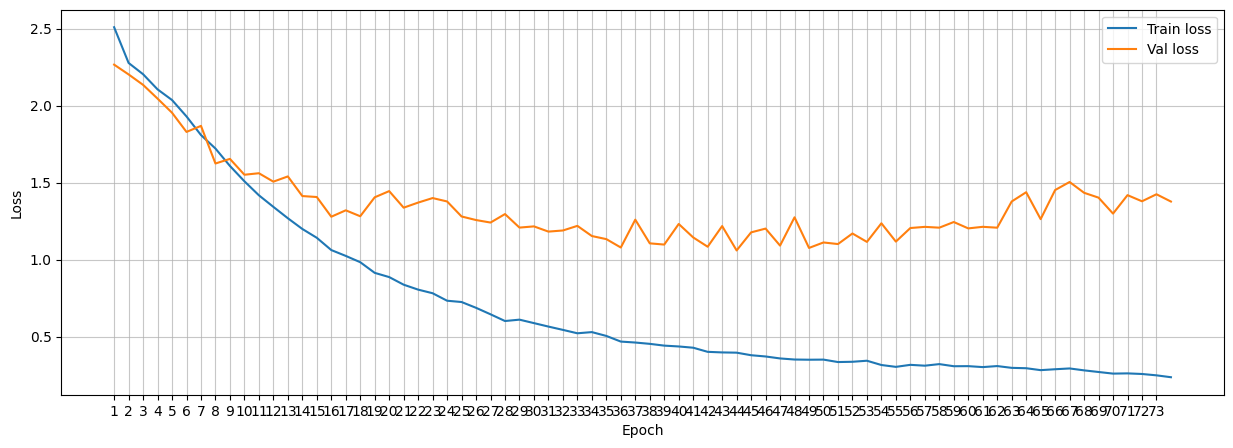

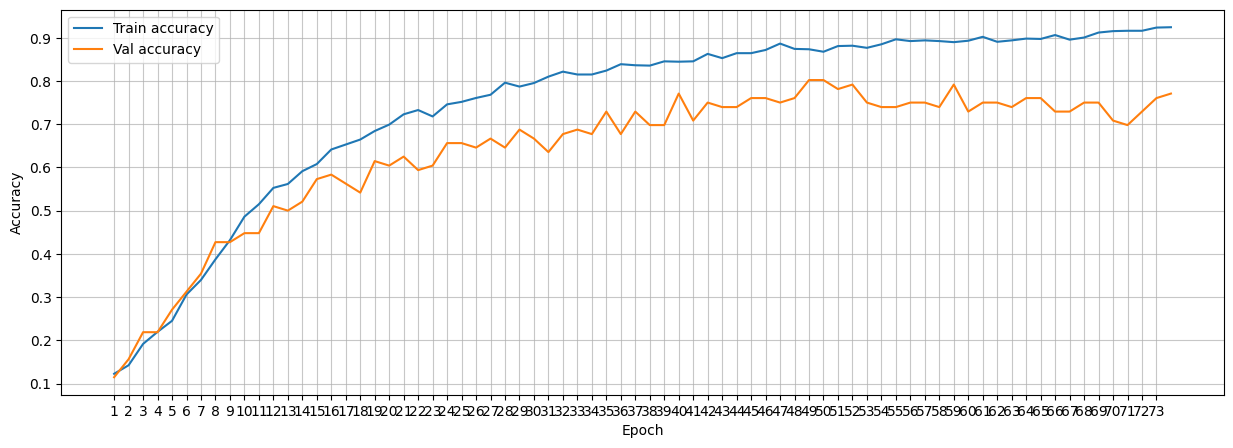

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6750 (67.50%)

MACRO AVERAGES:
  F1-Score   : 0.6818
  Precision  : 0.6976
  Recall     : 0.6750

WEIGHTED AVERAGES:
  F1-Score   : 0.6818
  Precision  : 0.6976
  Recall     : 0.6750

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.7500   0.7500     0.7500  
clock_tick      0.4706   0.4444     0.5000  
crackling_fire  0.6250   0.6250     0.6250  
crying_baby     0.9333   1.0000     0.8750  
dog             0.7059   0.6667     0.7500  
helicopter      0.7500   0.7500     0.7500  
rain            0.5263   0.4545     0.6250  
rooster         0.8571   1.0000     0.7500  
sea_waves       0.5333   0.5714     0.5000  
sneezing        0.6667   0.7143     0.6250  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.7500    0.7500    0.7500 

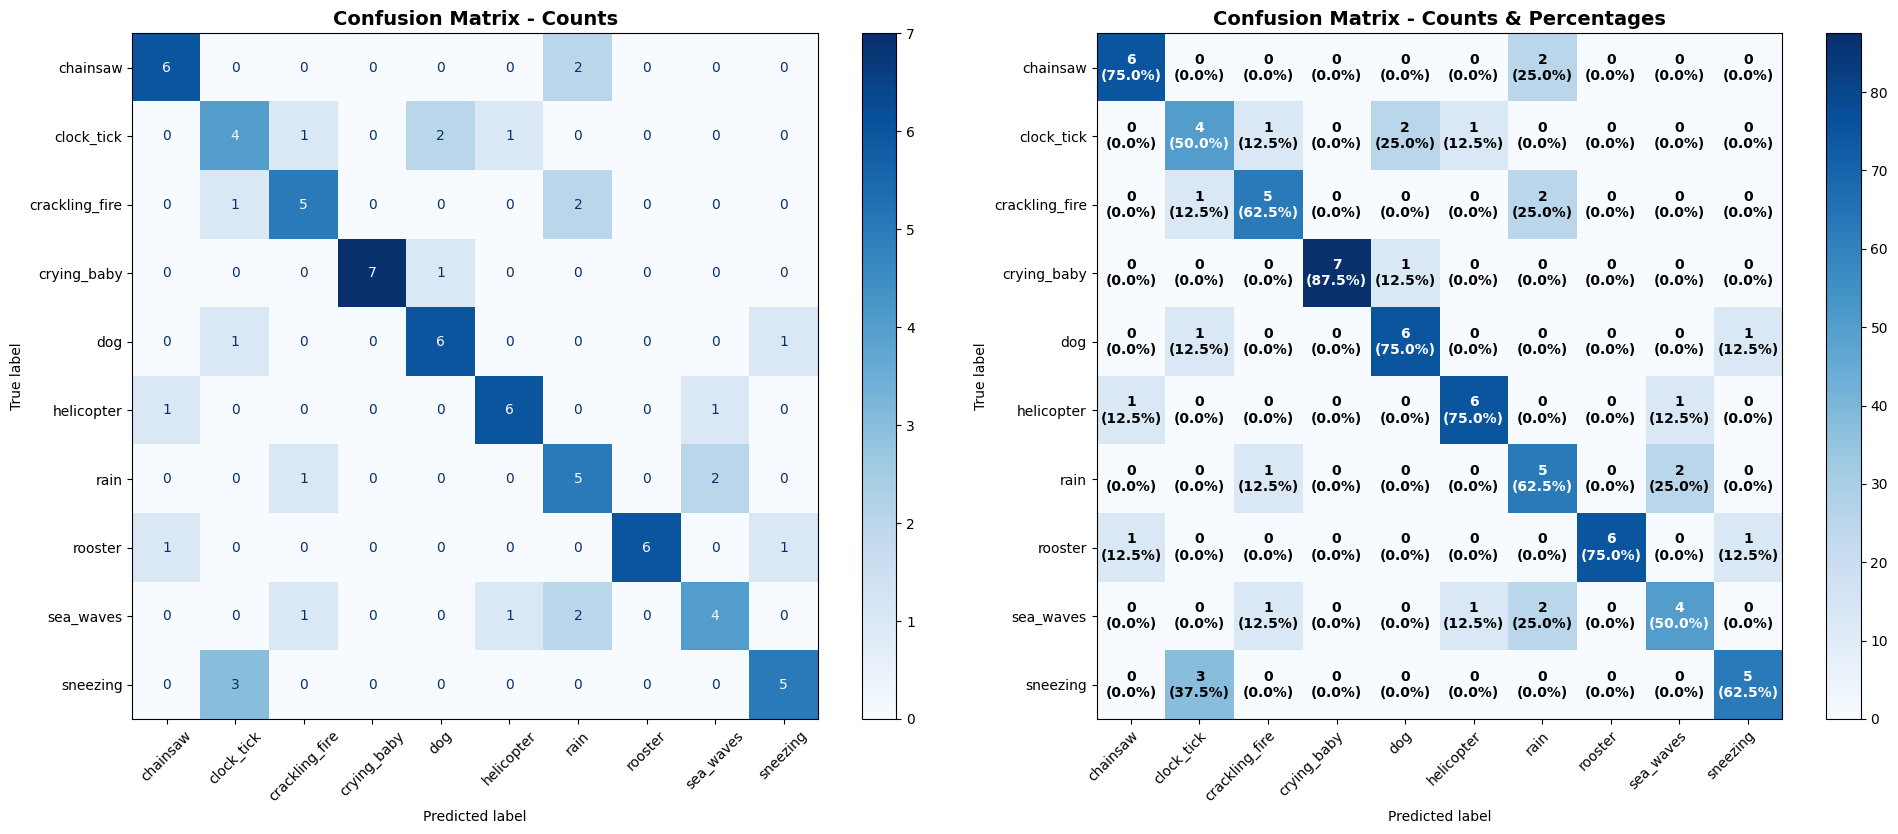


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        6        8        75.00     %
clock_tick      4        8        50.00     %
crackling_fire  5        8        62.50     %
crying_baby     7        8        87.50     %
dog             6        8        75.00     %
helicopter      6        8        75.00     %
rain            5        8        62.50     %
rooster         6        8        75.00     %
sea_waves       4        8        50.00     %
sneezing        5        8        62.50     %


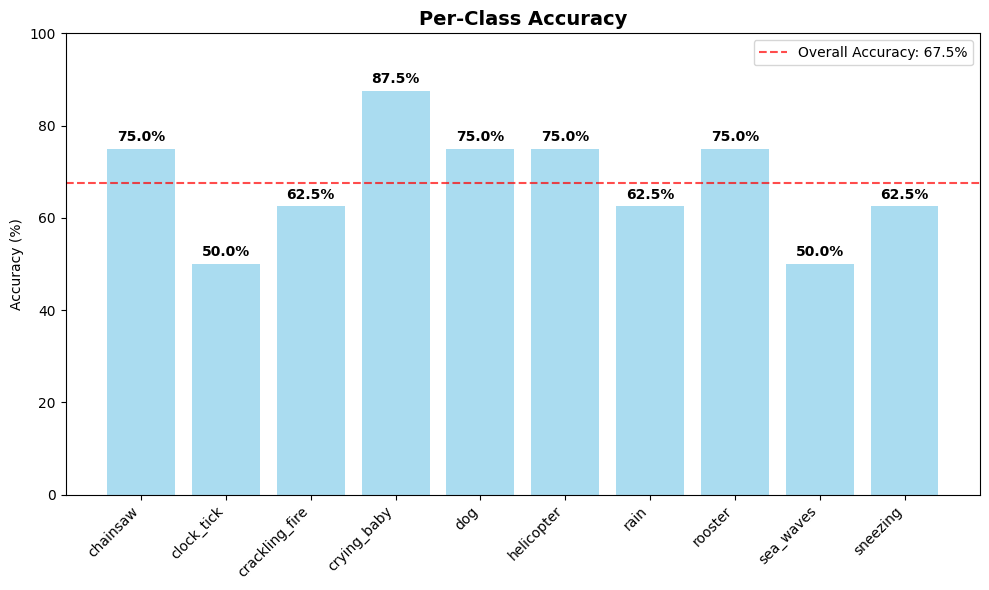

In [59]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]

results = evaluate_model_comprehensive(c_snn_model, sf_test_dataloader, class_names, device)

# Complexity and Performance Evaluation

In [1]:
from collections import defaultdict
import gc

class PerformanceProfiler:
    """
    Comprehensive performance profiler for SNN models
    """

    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.metrics = defaultdict(list)

    def profile_inference(self, dataloader, num_batches=None, warmup_batches=3):
        """
        Profile inference performance with detailed metrics
        """
        print("="*60)
        print("INFERENCE PERFORMANCE PROFILING")
        print("="*60)

        self.model.eval()

        # Metrics storage
        batch_times = []
        memory_usage = []
        gpu_memory = []
        cpu_usage = []

        total_samples = 0
        total_batches = 0

        # GPU memory tracking (if available)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(dataloader):
                if num_batches and batch_idx >= num_batches + warmup_batches:
                    break

                X = X.squeeze().to(self.device)
                y = y.squeeze().long().to(self.device)

                # Start timing after warmup
                if batch_idx >= warmup_batches:
                    torch.cuda.synchronize() if torch.cuda.is_available() else None
                    start_time = time.perf_counter()

                    # Memory before inference
                    process = psutil.Process()
                    cpu_mem_before = process.memory_info().rss / 1024**2  # MB
                    cpu_percent = psutil.cpu_percent(interval=None)

                # Forward pass
                spk_out, mem_out = self.model(X.float())

                if batch_idx >= warmup_batches:
                    torch.cuda.synchronize() if torch.cuda.is_available() else None
                    end_time = time.perf_counter()

                    # Record metrics
                    batch_time = end_time - start_time
                    batch_times.append(batch_time)

                    # Memory usage
                    cpu_mem_after = process.memory_info().rss / 1024**2  # MB
                    memory_usage.append(cpu_mem_after)
                    cpu_usage.append(cpu_percent)

                    if torch.cuda.is_available():
                        gpu_mem = torch.cuda.memory_allocated() / 1024**2  # MB
                        gpu_memory.append(gpu_mem)

                    total_samples += X.shape[0]
                    total_batches += 1

                # Cleanup
                del X, y, spk_out, mem_out

        # Calculate statistics
        batch_times = np.array(batch_times)
        memory_usage = np.array(memory_usage)
        cpu_usage = np.array(cpu_usage)

        results = {
            'batch_times': batch_times,
            'memory_usage': memory_usage,
            'cpu_usage': cpu_usage,
            'total_samples': total_samples,
            'total_batches': total_batches,
            'avg_batch_time': np.mean(batch_times),
            'std_batch_time': np.std(batch_times),
            'min_batch_time': np.min(batch_times),
            'max_batch_time': np.max(batch_times),
            'samples_per_second': total_samples / np.sum(batch_times),
            'avg_memory': np.mean(memory_usage),
            'peak_memory': np.max(memory_usage),
            'avg_cpu': np.mean(cpu_usage),
        }

        if torch.cuda.is_available():
            gpu_memory = np.array(gpu_memory)
            results.update({
                'gpu_memory': gpu_memory,
                'avg_gpu_memory': np.mean(gpu_memory),
                'peak_gpu_memory': np.max(gpu_memory),
                'pytorch_peak_memory': torch.cuda.max_memory_allocated() / 1024**2
            })

        return results

    def profile_training_step(self, train_loader, optimizer, loss_fn, accuracy_fn, num_batches=10):
        """
        Profile a few training steps to measure training performance
        """
        print("="*60)
        print("TRAINING PERFORMANCE PROFILING")
        print("="*60)

        self.model.train()

        # Enable mixed precision if available
        scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

        batch_times = []
        forward_times = []
        backward_times = []
        memory_usage = []
        gpu_memory = []

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        for batch_idx, (X, y) in enumerate(train_loader):
            if batch_idx >= num_batches:
                break

            X = X.squeeze().to(self.device)
            y = y.squeeze().long().to(self.device)

            # Start timing
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            batch_start = time.perf_counter()

            optimizer.zero_grad(set_to_none=True)

            # Forward pass timing
            forward_start = time.perf_counter()
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = self.model(X.float())
                    acc = accuracy_fn(spk_out, y)
                    loss = loss_fn(spk_out, y)
            else:
                spk_out, _ = self.model(X.float())
                acc = accuracy_fn(spk_out, y)
                loss = loss_fn(spk_out, y)

            torch.cuda.synchronize() if torch.cuda.is_available() else None
            forward_end = time.perf_counter()
            forward_times.append(forward_end - forward_start)

            # Backward pass timing
            backward_start = time.perf_counter()
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            torch.cuda.synchronize() if torch.cuda.is_available() else None
            backward_end = time.perf_counter()
            backward_times.append(backward_end - backward_start)

            batch_end = time.perf_counter()
            batch_times.append(batch_end - batch_start)

            # Memory tracking
            process = psutil.Process()
            memory_usage.append(process.memory_info().rss / 1024**2)

            if torch.cuda.is_available():
                gpu_memory.append(torch.cuda.memory_allocated() / 1024**2)

            del X, y, spk_out, loss, acc

        results = {
            'batch_times': np.array(batch_times),
            'forward_times': np.array(forward_times),
            'backward_times': np.array(backward_times),
            'memory_usage': np.array(memory_usage),
            'avg_batch_time': np.mean(batch_times),
            'avg_forward_time': np.mean(forward_times),
            'avg_backward_time': np.mean(backward_times),
            'peak_memory': np.max(memory_usage),
        }

        if torch.cuda.is_available():
            results.update({
                'gpu_memory': np.array(gpu_memory),
                'peak_gpu_memory': np.max(gpu_memory),
                'pytorch_peak_memory': torch.cuda.max_memory_allocated() / 1024**2
            })

        return results

    def analyze_model_complexity(self):
        """
        Analyze model complexity metrics
        """
        print("="*60)
        print("MODEL COMPLEXITY ANALYSIS")
        print("="*60)

        # Count parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)

        # Model size in MB
        param_size = 0
        buffer_size = 0

        for param in self.model.parameters():
            param_size += param.nelement() * param.element_size()

        for buffer in self.model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()

        model_size_mb = (param_size + buffer_size) / 1024**2

        # Memory estimate for different batch sizes
        def estimate_memory(batch_size, time_steps=450, n_mels=128):
            # Input tensor memory
            input_memory = batch_size * time_steps * n_mels * 4 / 1024**2  # float32 = 4 bytes

            # Rough estimate of intermediate activations (depends on architecture)
            activation_memory = input_memory * 3  # Conservative estimate

            return input_memory + activation_memory + model_size_mb

        complexity_metrics = {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_size_mb': model_size_mb,
            'memory_estimates': {
                'batch_1': estimate_memory(1),
                'batch_16': estimate_memory(16),
                'batch_32': estimate_memory(32),
                'batch_64': estimate_memory(64)
            }
        }

        return complexity_metrics

    def benchmark_encoding_methods(self, X_sample, thresholds=[0.02, 0.04, 0.05, 0.06, 0.08, 0.1]):
        """
        Benchmark different Step Forward encoding thresholds
        """
        print("="*60)
        print("STEP FORWARD ENCODING BENCHMARK")
        print("="*60)

        encoding_results = {}

        for threshold in thresholds:
            encoding_times = []
            spike_counts = []

            for _ in range(10):  # Multiple runs for averaging
                start_time = time.perf_counter()

                # Apply Step Forward encoding (simplified version)
                spike_train = torch.zeros(X_sample.shape[1], X_sample.shape[0], dtype=torch.int8)

                for mel_idx in range(X_sample.shape[0]):
                    input_signal = X_sample[mel_idx].numpy()
                    spikes = self._step_forward_encode(input_signal, threshold)
                    spike_train[:, mel_idx] = torch.from_numpy(spikes)

                end_time = time.perf_counter()
                encoding_times.append(end_time - start_time)
                spike_counts.append(spike_train.abs().sum().item())

            encoding_results[threshold] = {
                'avg_encoding_time': np.mean(encoding_times),
                'std_encoding_time': np.std(encoding_times),
                'avg_spike_count': np.mean(spike_counts),
                'spikes_per_second': np.mean(spike_counts) / np.mean(encoding_times)
            }

        return encoding_results

    def _step_forward_encode(self, input_signal, threshold):
        """Helper function for Step Forward encoding"""
        L = len(input_signal)
        spikes = np.zeros(L, dtype=np.int8)
        base = input_signal[0]

        for i in range(1, L):
            if input_signal[i] > base + threshold:
                spikes[i] = 1
                base = base + threshold
            elif input_signal[i] < base - threshold:
                spikes[i] = -1
                base = base - threshold

        return spikes

    def plot_performance_results(self, inference_results, training_results=None):
        """
        Create comprehensive performance visualization
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Inference timing distribution
        axes[0, 0].hist(inference_results['batch_times'] * 1000, bins=20, alpha=0.7, color='blue')
        axes[0, 0].set_title('Inference Time Distribution')
        axes[0, 0].set_xlabel('Time per Batch (ms)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(inference_results['avg_batch_time'] * 1000, color='red',
                           linestyle='--', label=f'Mean: {inference_results["avg_batch_time"]*1000:.2f}ms')
        axes[0, 0].legend()

        # Memory usage over time
        axes[0, 1].plot(inference_results['memory_usage'], label='CPU Memory', color='green')
        if 'gpu_memory' in inference_results:
            axes[0, 1].plot(inference_results['gpu_memory'], label='GPU Memory', color='orange')
        axes[0, 1].set_title('Memory Usage During Inference')
        axes[0, 1].set_xlabel('Batch Index')
        axes[0, 1].set_ylabel('Memory (MB)')
        axes[0, 1].legend()

        # CPU usage
        axes[0, 2].plot(inference_results['cpu_usage'], color='purple')
        axes[0, 2].set_title('CPU Usage During Inference')
        axes[0, 2].set_xlabel('Batch Index')
        axes[0, 2].set_ylabel('CPU Usage (%)')

        if training_results:
            # Training time breakdown
            times = [training_results['avg_forward_time'], training_results['avg_backward_time']]
            labels = ['Forward Pass', 'Backward Pass']
            colors = ['lightblue', 'lightcoral']

            axes[1, 0].bar(labels, np.array(times) * 1000, color=colors)
            axes[1, 0].set_title('Training Time Breakdown')
            axes[1, 0].set_ylabel('Average Time (ms)')

            # Training memory usage
            axes[1, 1].plot(training_results['memory_usage'], label='CPU Memory', color='green')
            if 'gpu_memory' in training_results:
                axes[1, 1].plot(training_results['gpu_memory'], label='GPU Memory', color='orange')
            axes[1, 1].set_title('Memory Usage During Training')
            axes[1, 1].set_xlabel('Batch Index')
            axes[1, 1].set_ylabel('Memory (MB)')
            axes[1, 1].legend()

            # Training vs inference comparison
            comparison_data = {
                'Inference': inference_results['avg_batch_time'] * 1000,
                'Training': training_results['avg_batch_time'] * 1000
            }
            axes[1, 2].bar(comparison_data.keys(), list(comparison_data.values()),
                          color=['skyblue', 'salmon'])
            axes[1, 2].set_title('Training vs Inference Speed')
            axes[1, 2].set_ylabel('Average Time per Batch (ms)')
        else:
            # Hide unused subplots
            axes[1, 0].set_visible(False)
            axes[1, 1].set_visible(False)
            axes[1, 2].set_visible(False)

        plt.tight_layout()
        plt.show()

    def generate_performance_report(self, inference_results, training_results, complexity_metrics, encoding_results):
        """
        Generate a comprehensive performance report
        """
        print("\n" + "="*80)
        print("COMPREHENSIVE PERFORMANCE REPORT - STEP FORWARD SNN")
        print("="*80)

        print("\n🚀 INFERENCE PERFORMANCE:")
        print(f"  Average batch time: {inference_results['avg_batch_time']*1000:.2f} ± {inference_results['std_batch_time']*1000:.2f} ms")
        print(f"  Throughput: {inference_results['samples_per_second']:.1f} samples/second")
        print(f"  Min/Max batch time: {inference_results['min_batch_time']*1000:.2f} / {inference_results['max_batch_time']*1000:.2f} ms")
        print(f"  CPU usage: {inference_results['avg_cpu']:.1f}%")
        print(f"  Peak CPU memory: {inference_results['peak_memory']:.1f} MB")

        if 'peak_gpu_memory' in inference_results:
          print(f"  Peak GPU memory: {inference_results['peak_gpu_memory']:.1f} MB")

        if training_results:
            print("\n🏋️ TRAINING PERFORMANCE:")
            print(f"  Average batch time: {training_results['avg_batch_time']*1000:.2f} ms")
            print(f"  Forward pass: {training_results['avg_forward_time']*1000:.2f} ms")
            print(f"  Backward pass: {training_results['avg_backward_time']*1000:.2f} ms")
            print(f"  Peak CPU memory: {training_results['peak_memory']:.1f} MB")

            if 'peak_gpu_memory' in training_results:
                print(f"  Peak GPU memory: {training_results['peak_gpu_memory']:.1f} MB")

        print("\n🧠 MODEL COMPLEXITY:")
        print(f"  Total parameters: {complexity_metrics['total_parameters']:,}")
        print(f"  Trainable parameters: {complexity_metrics['trainable_parameters']:,}")
        print(f"  Model size: {complexity_metrics['model_size_mb']:.2f} MB")

        print("\n  Estimated memory usage by batch size:")
        for batch_size, memory in complexity_metrics['memory_estimates'].items():
            print(f"    {batch_size}: {memory:.1f} MB")


def run_performance_evaluation(model, train_loader, val_loader, test_loader, device):
    """
    Run comprehensive performance evaluation
    """
    profiler = PerformanceProfiler(model, device)

    # 1. Analyze model complexity
    complexity_metrics = profiler.analyze_model_complexity()

    # 2. Profile inference performance
    inference_results = profiler.profile_inference(test_loader, num_batches=5, warmup_batches=0)  # Will use all available

    # 3. Profile training performance (optional - comment out if you don't want to run training)
    training_results = profiler.profile_training_step(
        train_loader,
        torch.optim.Adam(model.parameters(), lr=0.0001),
        snn.functional.ce_count_loss(),
        SF.acc.accuracy_rate,
        num_batches=10
    )
    #training_results = None  # Set to None if not running training profiling

    # 4. Benchmark encoding methods
    sample_batch = next(iter(val_loader))
    X_sample = sample_batch[0][0].squeeze(-1)  # Get first sample
    encoding_results = profiler.benchmark_encoding_methods(X_sample)

    # 5. Generate visualizations
    profiler.plot_performance_results(inference_results, training_results)

    # 6. Generate comprehensive report
    profiler.generate_performance_report(
        inference_results, training_results,
        complexity_metrics, encoding_results
    )

    return {
        'training': training_results,
        'complexity': complexity_metrics,
        'encoding': encoding_results
    }

## Simple SNN complexity and performance evaluation

In [49]:
performance_results = run_performance_evaluation(
    model=snn_classifier,
    train_loader=sf_train_dataloader,
    val_loader=sf_val_dataloader,
    test_loader=sf_test_dataloader,
    device=device
)

NameError: name 'snn_classifier' is not defined

## CSNN Complexity And Performance Evaluation

MODEL COMPLEXITY ANALYSIS
INFERENCE PERFORMANCE PROFILING
TRAINING PERFORMANCE PROFILING


/tmp/ipython-input-54-822336417.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


STEP FORWARD ENCODING BENCHMARK


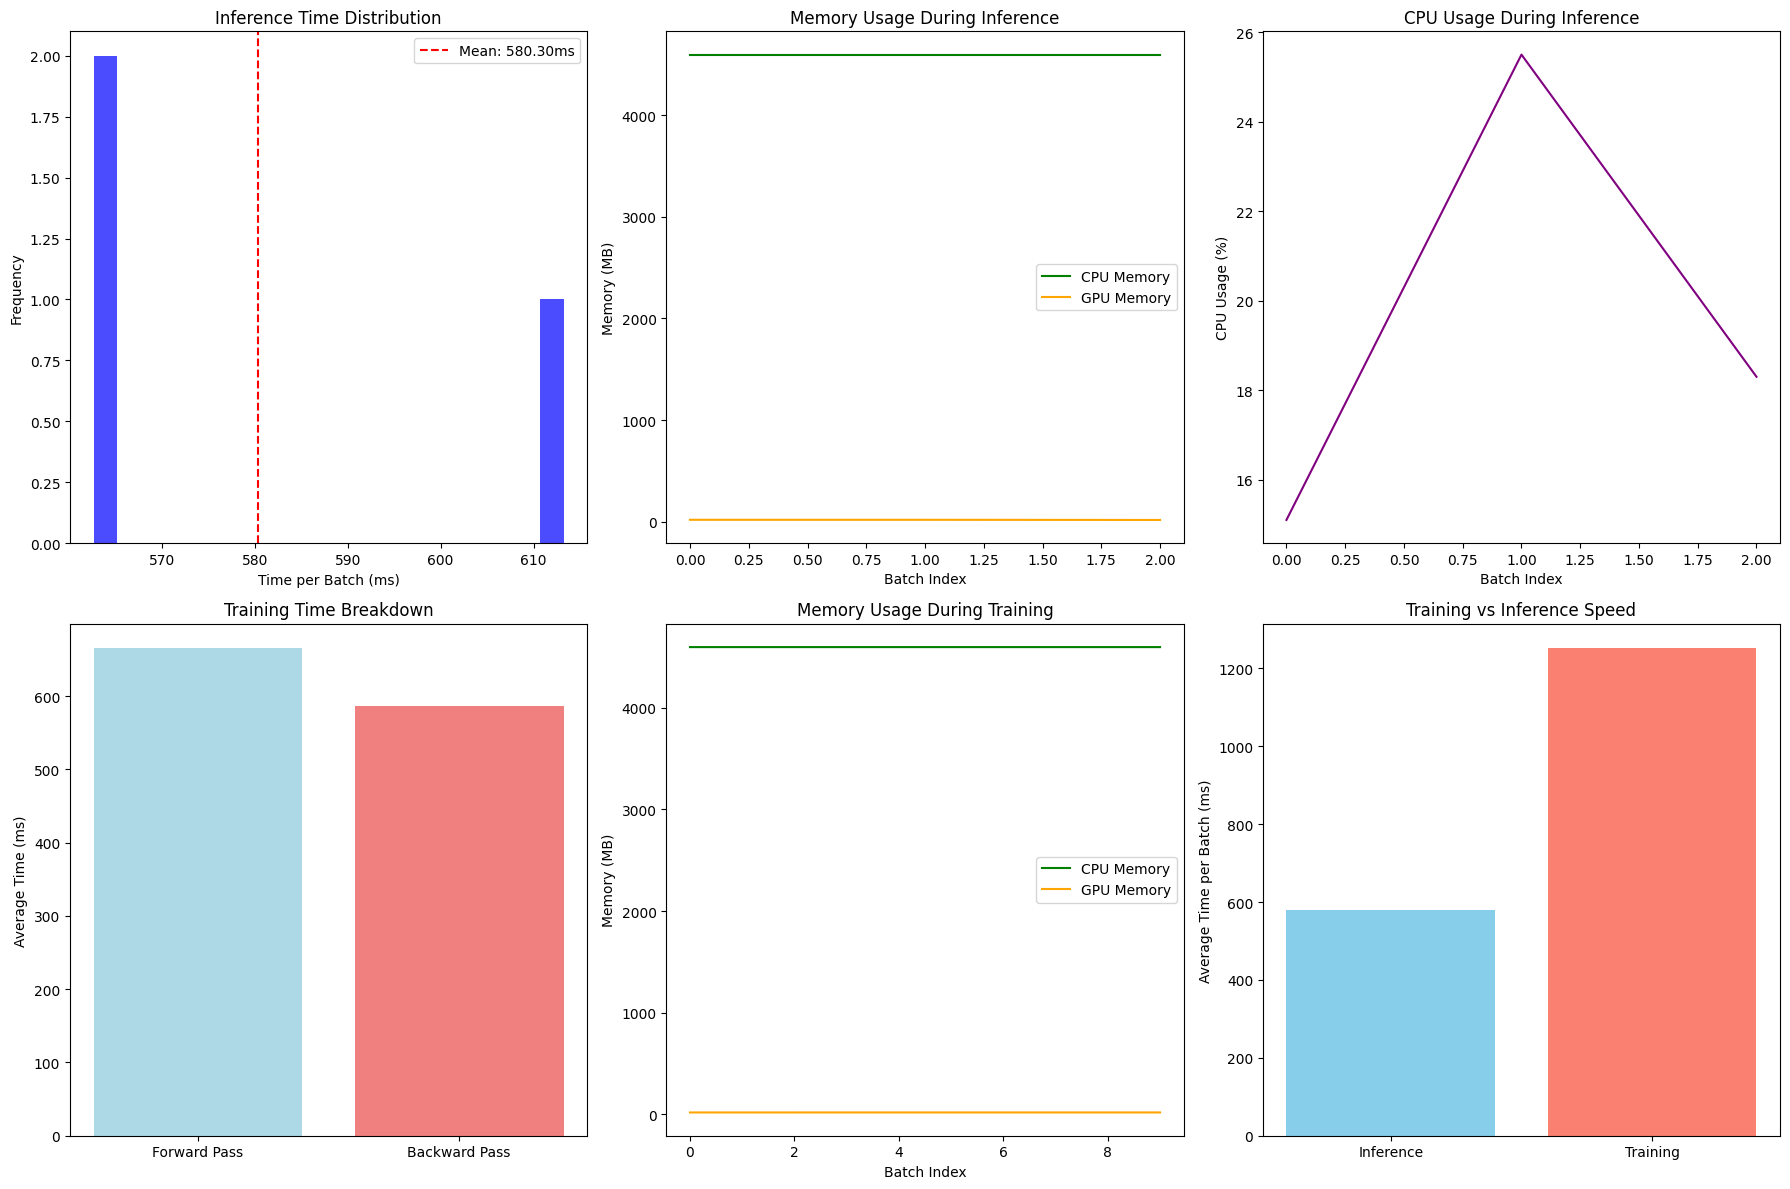


COMPREHENSIVE PERFORMANCE REPORT - STEP FORWARD SNN

🚀 INFERENCE PERFORMANCE:
  Average batch time: 580.30 ± 23.31 ms
  Throughput: 46.0 samples/second
  Min/Max batch time: 562.64 / 613.23 ms
  CPU usage: 19.6%
  Peak CPU memory: 4594.4 MB
  Peak GPU memory: 19.7 MB

🏋️ TRAINING PERFORMANCE:
  Average batch time: 1251.73 ms
  Forward pass: 665.39 ms
  Backward pass: 586.15 ms
  Peak CPU memory: 4594.4 MB
  Peak GPU memory: 19.8 MB

🧠 MODEL COMPLEXITY:
  Total parameters: 5,148
  Trainable parameters: 5,148
  Model size: 0.08 MB

  Estimated memory usage by batch size:
    batch_1: 1.0 MB
    batch_16: 14.1 MB
    batch_32: 28.2 MB
    batch_64: 56.3 MB


In [60]:
performance_results = run_performance_evaluation(
    model=c_snn_model,
    train_loader=sf_train_dataloader,
    val_loader=sf_val_dataloader,
    test_loader=sf_test_dataloader,
    device=device
)